# Integrated Gradients Visualization

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer
from transformers import pipeline



model = AutoModelForSequenceClassification.from_pretrained(
    "weighted_loss/Molformer_WL",num_labels=2,trust_remote_code=True
).to(device)
tokenizer = AutoTokenizer.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct",trust_remote_code=True
)
model.eval()

cls_explainer = SequenceClassificationExplainer(model, tokenizer)

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer,device=device)

Device set to use cpu


In [4]:
print(model.config.id2label)

{0: 'LABEL_0', 1: 'LABEL_1'}


### Utils

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit
from IPython.display import Image
print(rdkit.__version__)

2022.09.5


In [ ]:
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
from sklearn.metrics import matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score
import torch
import numpy as np

def evaluate_single_smiles(smiles_string, true_label=None):  # optionally pass true label

    # Tokenize
    inputs = tokenizer(smiles_string, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()

    
    probabilities = softmax(np.squeeze(logits), axis=0).reshape(1, -1)
    
    
    prediction = np.argmax(probabilities, axis=1)[0]
    score = probabilities[0, prediction].item()
    

    print("Logits:", logits)
    print("Probabilities:", probabilities)
    print("Predicted class:", prediction)
    print("Score:", score)



   


In [ ]:
import torch.nn.functional as F
from scipy.special import softmax

def get_output_from_smiles(smiles):
    # Ensure the model is in eval mode and on the right device
    model.eval()
    model.to(device)

    inputs = tokenizer(smiles, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()

    
    probabilities = softmax(np.squeeze(logits), axis=0).reshape(1, -1)
    
    
    prediction = np.argmax(probabilities, axis=1)[0]
    score = probabilities[0, prediction].item()
    
    print(prediction)
    print(probabilities)
    
    

    # Map to taste label
    taste_labels = ['0','1']
    new_label = taste_labels[prediction]

    # Format output
    title_string = f"{new_label} score: {score:.2f}"
    
    return title_string


def calculate_aspect_ratio(molecule, base_size):
    """
    Calculates the canvas width and height based on the molecule's aspect ratio.

    Parameters:
    - molecule (Mol): RDKit molecule object.
    - base_size (int): The base size of the canvas, typically 400.

    Returns:
    - (int, int): Calculated width and height for the canvas.
    """
    conf = molecule.GetConformer()
    atom_positions = [conf.GetAtomPosition(i) for i in range(molecule.GetNumAtoms())]
    x_coords = [pos.x for pos in atom_positions]
    y_coords = [pos.y for pos in atom_positions]
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)
    aspect_ratio = width / height if height > 0 else 1

    canvas_width = max(base_size, int(base_size * aspect_ratio)) if aspect_ratio > 1 else base_size
    canvas_height = max(base_size, int(base_size / aspect_ratio)) if aspect_ratio < 1 else base_size

    return canvas_width, canvas_height 

def visualize_gradients(smiles, bw=True, padding=0.05):
    
    """
    Visualizes atom-wise gradients or importance scores for a given molecule 
    based on the SMILES representation as a similarity map.

    Parameters:
    - smiles (str): The SMILES string of the molecule to visualize.
    - bw (bool): If True, renders the molecule in black and white (default is False).

    Returns:
    - None: Displays the generated similarity map in the notebook.
    """
    
    
    print(get_output_from_smiles(smiles))

    # Convert SMILES string to RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)
    Chem.rdDepictor.Compute2DCoords(molecule)
    
    # Set up canvas size based on aspect ratio
    base_size = 400
    width, height = calculate_aspect_ratio(molecule, base_size)
    d = Draw.MolDraw2DCairo(width, height)
    d.drawOptions().padding = padding
    
    # Optionally set black and white palette
    if bw:
        d.drawOptions().useBWAtomPalette()
    
    # Get token importance scores and map to atoms
    token_importance = cls_explainer(smiles)
    
    atom_importance = [c[1] for c in token_importance if c[0].isalpha()]
    num_atoms = molecule.GetNumAtoms()
    atom_importance = atom_importance[:num_atoms]
    
    print("atom imp",atom_importance)
    # Generate and display a similarity map based on atom importance scores
    SimilarityMaps.GetSimilarityMapFromWeights(molecule, atom_importance, draw2d=d)
    
    # Convert drawing to image and display
    d.FinishDrawing()
    png_data = d.GetDrawingText()
    img = Image(data=png_data)
    return img

In [8]:
def save_high_quality_png(smiles, title, bw=True, padding=0.05):
    """
    Generates a high-quality PNG of atom-wise gradients or importance scores for a molecule.

    Parameters:
    - smiles (str): The SMILES string of the molecule to visualize.
    - token_importance (list): List of importance scores for each atom.
    - bw (bool): If True, renders the molecule in black and white.
    - padding (float): Padding for molecule drawing.
    - output_file (str): Path to save the high-quality PNG file.

    Returns:
    - None
    """
    
    # Convert SMILES string to RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)
    Chem.rdDepictor.Compute2DCoords(molecule)
    
    # Get token importance scores and map to atoms
    token_importance = cls_explainer(smiles)
    #token_importance = [(token, float(score.cpu()) if hasattr(score, 'cpu') else float(score)) for token, score in token_importance]
    atom_importance = [c[1] for c in token_importance if c[0].isalpha()]
    num_atoms = molecule.GetNumAtoms()
    atom_importance = atom_importance[:num_atoms]
    
    # Set a large canvas size for high resolution
    d = Draw.MolDraw2DCairo(1500, 1500)

    dopts = d.drawOptions()
    dopts.padding = padding    
    dopts.maxFontSize = 2000
    dopts.bondLineWidth = 5

    # Optionally set black and white palette
    if bw:
        d.drawOptions().useBWAtomPalette()
    
    # Generate and display a similarity map based on atom importance scores
    SimilarityMaps.GetSimilarityMapFromWeights(molecule, atom_importance, draw2d=d)

    # Draw molecule with color highlights
    d.FinishDrawing()
    
    # Save to PNG file with high quality
    with open(f"{title}.png", "wb") as png_file:
        png_file.write(d.GetDrawingText())
    
    print(f"High-quality PNG file saved as {title}.png")
    d.FinishDrawing()
    png_data = d.GetDrawingText()
    img = Image(data=png_data)
    return img

## Plots for Molformer WL

## Permeable 1

1
[[0.43771484 0.5622852 ]]
1 score: 0.56
Token Importance: [('<bos>', 0.0), ('N', 0.41093483567237854), ('1', -0.08962658047676086), ('(', -0.13735583424568176), ('C', 0.015849389135837555), ('c', 0.02470952831208706), ('2', -0.09305943548679352), ('c', 0.040232300758361816), ('c', 0.048523761332035065), ('(', -0.08077765256166458), ('O', 0.3258128762245178), ('C', -0.018581246957182884), ('C', 0.004679468926042318), ('C', 0.021415479481220245), ('N', 0.35479453206062317), ('c', -0.007295134477317333), ('3', -0.21782590448856354), ('o', -0.019949354231357574), ('c', -0.01223851554095745), ('4', 0.07692475616931915), ('c', -0.0017233442049473524), ('c', 0.004478790797293186), ('c', 0.002756994217634201), ('c', -0.0019082844955846667), ('c', -0.013219952583312988), ('4', 0.13821004331111908), ('n', 0.014355790801346302), ('3', 0.6305311918258667), (')', 0.048064667731523514), ('c', 0.024917708709836006), ('c', 0.04020334780216217), ('c', 0.062776580452919), ('2', 0.043702419847249985), 

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.41093483567237854, 0.015849389135837555, 0.02470952831208706, 0.040232300758361816, 0.048523761332035065, 0.3258128762245178, -0.018581246957182884, 0.004679468926042318, 0.021415479481220245, 0.35479453206062317, -0.007295134477317333, -0.019949354231357574, -0.01223851554095745, -0.0017233442049473524, 0.004478790797293186, 0.002756994217634201, -0.0019082844955846667, -0.013219952583312988, 0.014355790801346302, 0.024917708709836006, 0.04020334780216217, 0.062776580452919, -0.01169978454709053, 0.0050559756346046925, 0.033759091049432755, 0.055675216019153595, 0.04907289892435074]


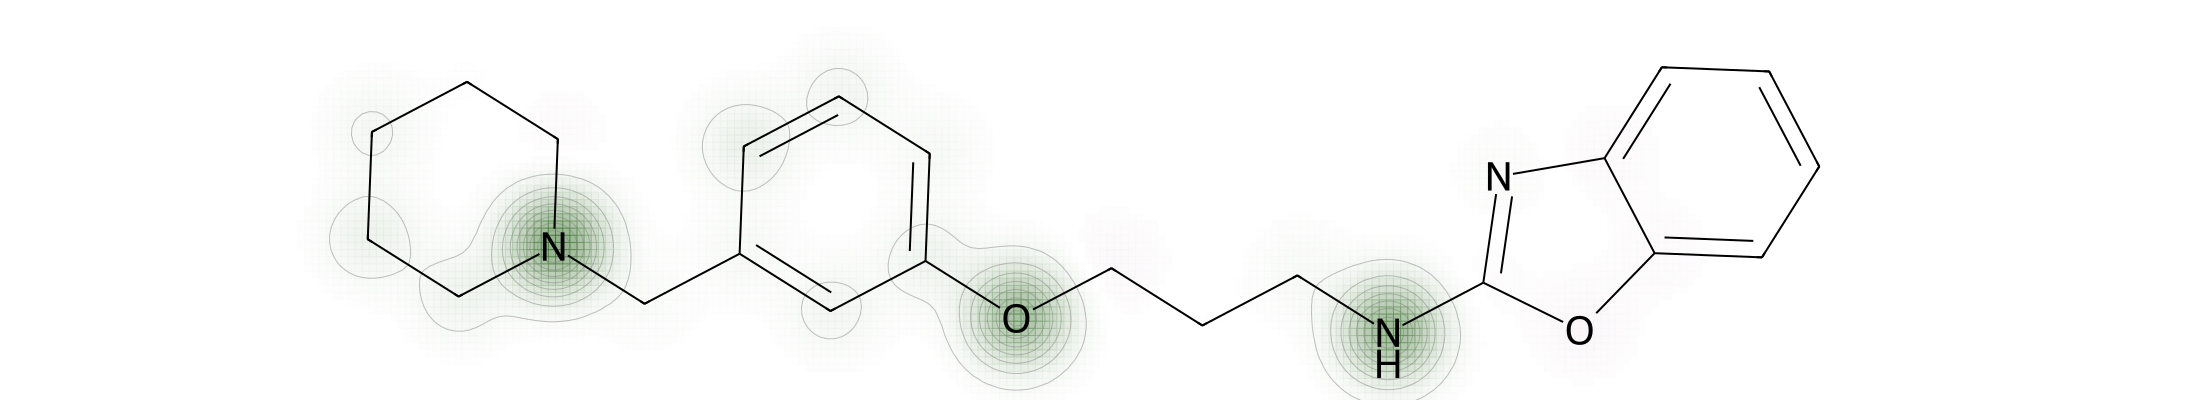

In [191]:
molecule= 'N1(Cc2cc(OCCCNc3oc4ccccc4n3)ccc2)CCCCC1'
visualize_gradients(molecule) #c

1
[[0.36984792 0.63015205]]
1 score: 0.63


Token Importance: [('<bos>', 0.0), ('N', -0.729192852973938), ('1', 0.038774218410253525), ('(', 0.06621160358190536), ('C', -0.010029896162450314), ('c', 0.008098466321825981), ('2', -0.039654411375522614), ('c', 0.019814522936940193), ('c', 0.02621479518711567), ('c', 0.01159973070025444), ('c', 0.01632283255457878), ('(', 0.02705386094748974), ('O', -0.055994000285863876), ('C', 0.006801758427172899), ('C', -0.01999543607234955), ('C', -0.058803997933864594), ('N', -0.06583251059055328), ('c', 0.039188265800476074), ('3', -0.031500570476055145), ('c', 0.01783103123307228), ('c', 0.01579093001782894), ('c', 0.012534184381365776), ('c', 0.011286565102636814), ('n', -0.06502945721149445), ('3', -0.2906550168991089), (')', -0.002842777408659458), ('c', 0.007366945501416922), ('2', -0.5906170010566711), (')', -0.043780576437711716), ('C', 0.03514072671532631), ('C', 0.02611582539975643), ('C', 0.02866695262491703), ('C', 0.022782986983656883), ('C', 0.028222572058439255), ('1', -0.010726

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [-0.729192852973938, -0.010029896162450314, 0.008098466321825981, 0.019814522936940193, 0.02621479518711567, 0.01159973070025444, 0.01632283255457878, -0.055994000285863876, 0.006801758427172899, -0.01999543607234955, -0.058803997933864594, -0.06583251059055328, 0.039188265800476074, 0.01783103123307228, 0.01579093001782894, 0.012534184381365776, 0.011286565102636814, -0.06502945721149445, 0.007366945501416922, 0.03514072671532631, 0.02611582539975643, 0.02866695262491703, 0.022782986983656883, 0.028222572058439255]


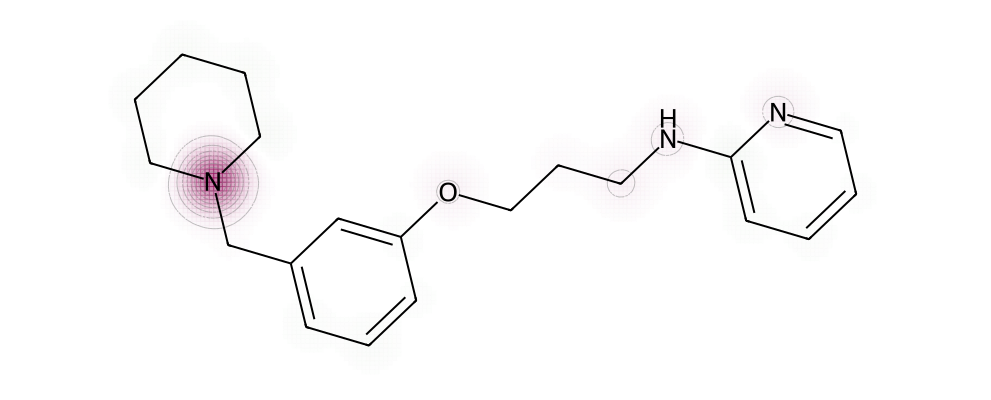

In [190]:
molecule= 'N1(Cc2cccc(OCCCNc3ccccn3)c2)CCCCC1'
visualize_gradients(molecule) #c

1
[[0.06139466 0.93860537]]
1 score: 0.94
Token Importance: [('<bos>', 0.0), ('C', -0.07788456976413727), ('N', -0.18209868669509888), ('1', -0.049981739372015), ('C', -0.04209174960851669), ('C', -0.03246168792247772), ('N', 0.016774136573076248), ('(', 0.08997654169797897), ('C', -0.0350181944668293), ('C', -0.027721388265490532), ('1', 0.029651058837771416), (')', -0.9085203409194946), ('C', -0.024530936032533646), ('2', -0.006473287474364042), ('=', 0.06199215352535248), ('N', -0.03438906744122505), ('c', -0.006208828650414944), ('3', 0.1277049332857132), ('c', -0.004197698552161455), ('c', -0.001914719701744616), ('c', -0.0035778465680778027), ('c', -0.014475786127150059), ('c', -0.011378828436136246), ('3', -0.021017879247665405), ('C', -0.03067420795559883), ('c', 0.03469438850879669), ('4', 0.14079569280147552), ('c', 0.005557229742407799), ('c', 0.00843594316393137), ('c', 0.0037730440963059664), ('c', 0.000824680202640593), ('c', 0.0026871312875300646), ('2', -0.1859045922756

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [-0.07788456976413727, -0.18209868669509888, -0.04209174960851669, -0.03246168792247772, 0.016774136573076248, -0.0350181944668293, -0.027721388265490532, -0.024530936032533646, -0.03438906744122505, -0.006208828650414944, -0.004197698552161455, -0.001914719701744616, -0.0035778465680778027, -0.014475786127150059, -0.011378828436136246, -0.03067420795559883, 0.03469438850879669, 0.005557229742407799, 0.00843594316393137, 0.0037730440963059664, 0.000824680202640593, 0.0026871312875300646]


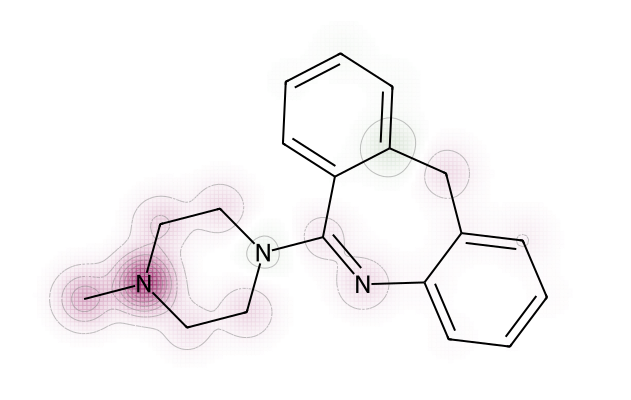

In [189]:
molecule= 'CN1CCN(CC1)C2=Nc3ccccc3Cc4ccccc24'
visualize_gradients(molecule) #c

0
[[0.78582734 0.21417269]]
0 score: 0.79
Token Importance: [('<bos>', 0.0), ('C', -0.07148698717355728), ('C', 0.0536997988820076), ('(', -0.062054842710494995), ('C', -0.0013274004450067878), (')', 0.05993856117129326), ('c', -0.0284085962921381), ('1', -0.06408403068780899), ('c', -0.009080026298761368), ('c', -0.03579368069767952), ('c', -0.04271293804049492), ('c', -0.005980391055345535), ('(', -0.10836538672447205), ('C', 0.11084851622581482), ('(', -0.10144174098968506), ('C', -0.025332268327474594), (')', 0.5784645676612854), ('C', -0.01242055743932724), (')', 0.7457133531570435), ('c', 0.18573302030563354), ('1', 0.108089879155159), ('O', 0.06645678728818893), ('<eos>', 0.0)]


/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [-0.07148698717355728, 0.0536997988820076, -0.0013274004450067878, -0.0284085962921381, -0.009080026298761368, -0.03579368069767952, -0.04271293804049492, -0.005980391055345535, 0.11084851622581482, -0.025332268327474594, -0.01242055743932724, 0.18573302030563354, 0.06645678728818893]


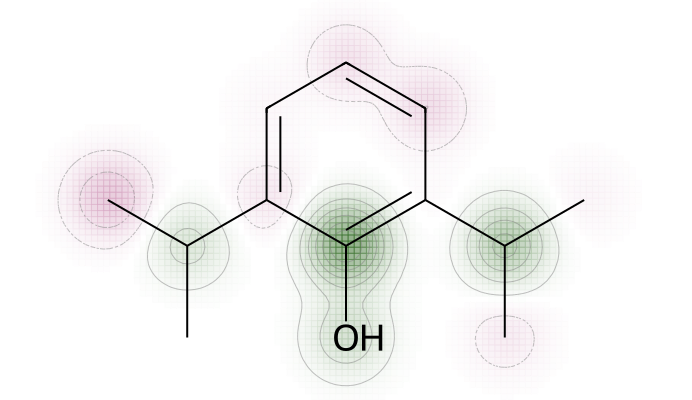

In [181]:
molecule= 'CC(C)c1cccc(C(C)C)c1O'
visualize_gradients(molecule) #w

1
[[0.02458174 0.97541827]]
1 score: 0.98
Token Importance: [('<bos>', 0.0), ('C', 0.11384889483451843), ('N', 0.0832521915435791), ('(', 0.28623542189598083), ('C', 0.18860548734664917), (')', -0.12894797325134277), ('C', -0.05811738222837448), ('C', -0.06680610775947571), ('C', 0.029265623539686203), ('N', 0.16634149849414825), ('1', 0.1341632902622223), ('c', -0.10466136783361435), ('2', -0.16118741035461426), ('c', -0.004072226583957672), ('c', -0.1836770474910736), ('c', 0.020395396277308464), ('c', 0.0478663295507431), ('c', -0.12848521769046783), ('2', -0.12527592480182648), ('S', -0.010890933685004711), ('c', -0.06587357819080353), ('3', -0.242690771818161), ('c', -0.006626826710999012), ('c', 0.039157066494226456), ('c', 0.021154409274458885), ('(', 0.15156716108322144), ('c', -0.00018164362700190395), ('c', 0.06574264913797379), ('1', 0.12002359330654144), ('3', 0.09783351421356201), (')', -0.292770653963089), ('C', 0.05798334255814552), ('(', -0.21555735170841217), ('F', -0.

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.11384889483451843, 0.0832521915435791, 0.18860548734664917, -0.05811738222837448, -0.06680610775947571, 0.029265623539686203, 0.16634149849414825, -0.10466136783361435, -0.004072226583957672, -0.1836770474910736, 0.020395396277308464, 0.0478663295507431, -0.12848521769046783, -0.010890933685004711, -0.06587357819080353, -0.006626826710999012, 0.039157066494226456, 0.021154409274458885, -0.00018164362700190395, 0.06574264913797379, 0.05798334255814552, -0.5567634105682373, -0.1919436901807785, -0.20708727836608887]


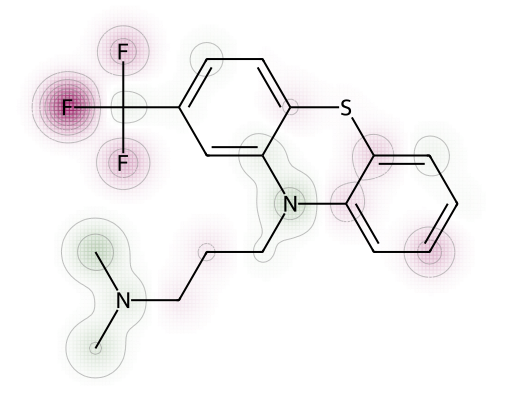

In [180]:
molecule= 'CN(C)CCCN1c2ccccc2Sc3ccc(cc13)C(F)(F)F'
visualize_gradients(molecule) #c

1
[[8.3568488e-04 9.9916434e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', 0.27146080136299133), ('(', 0.270245224237442), ('N', 0.19843296706676483), ('1', 0.17183136940002441), ('C', 0.12055214494466782), ('(', 0.286609023809433), ('C', 0.07074952125549316), ('(', 0.5307939052581787), ('C', -0.12354356795549393), (')', -0.043490439653396606), ('O', -0.19584479928016663), ('C', -0.02889391966164112), ('1', -0.09778515249490738), ('=', 0.06700252741575241), ('O', -0.30857768654823303), (')', -0.07430943101644516), ('=', -0.08714968711137772), ('O', -0.3602112829685211), (')', 0.17832672595977783), ('C', -0.13969536125659943), ('=', 0.05990738049149513), ('C', 0.193805530667305), ('<eos>', 0.0)]


/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.27146080136299133, 0.19843296706676483, 0.12055214494466782, 0.07074952125549316, -0.12354356795549393, -0.19584479928016663, -0.02889391966164112, -0.30857768654823303, -0.3602112829685211, -0.13969536125659943, 0.193805530667305]


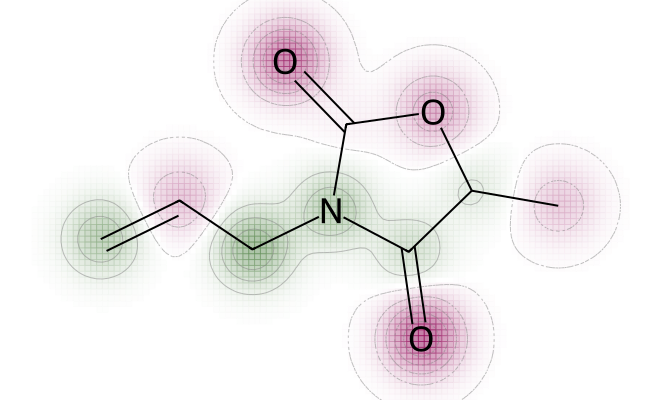

In [148]:
molecule= 'C(N1C(C(C)OC1=O)=O)C=C'
visualize_gradients(molecule) #c

1
[[0.07129395 0.92870605]]
1 score: 0.93
Token Importance: [('<bos>', 0.0), ('C', 0.19813032448291779), ('1', -0.7697167992591858), ('C', 0.12564241886138916), ('O', -0.4138098657131195), ('C', 0.26767781376838684), ('C', 0.10234324634075165), ('N', 0.31118258833885193), ('1', -0.04791329428553581), ('<eos>', 0.0)]


/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.19813032448291779, 0.12564241886138916, -0.4138098657131195, 0.26767781376838684, 0.10234324634075165, 0.31118258833885193]


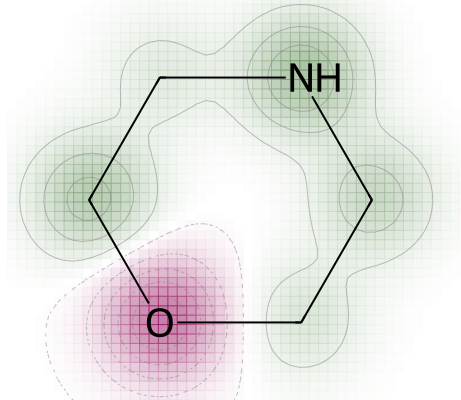

In [121]:
molecule= 'C1COCCN1'
visualize_gradients(molecule) #c

1
[[2.1720660e-04 9.9978286e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', -0.026896050199866295), ('1', 0.13935062289237976), ('=', 0.215168297290802), ('C', -0.21535539627075195), ('(', 0.3961295187473297), ('Cl', 0.1887805163860321), (')', -0.14786580204963684), ('C', -0.14810627698898315), ('=', 0.08204451203346252), ('C', -0.13940544426441193), ('C', -0.09921669960021973), ('(', 0.27983078360557556), ('=', 0.032992128282785416), ('C', -0.02488134056329727), ('1', 0.012644224800169468), ('C', -0.11900682747364044), ('(', 0.2126091867685318), ('C', -0.061066336929798126), ('2', -0.02034243382513523), ('=', 0.1009049192070961), ('C', -0.12879537045955658), ('(', 0.30125510692596436), ('C', -0.15553341805934906), ('=', 0.03309832513332367), ('C', -0.13344533741474152), ('C', -0.15593785047531128), ('=', 0.033507321029901505), ('C', 0.009812073782086372), ('2', -0.06565220654010773), (')', 0.023265467956662178), ('Cl', 0.2354286164045334), (')', 0.14344023168087006), ('='

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [-0.026896050199866295, -0.21535539627075195, 0.1887805163860321, -0.14810627698898315, -0.13940544426441193, -0.09921669960021973, -0.02488134056329727, -0.11900682747364044, -0.061066336929798126, -0.12879537045955658, -0.15553341805934906, -0.13344533741474152, -0.15593785047531128, 0.009812073782086372, 0.2354286164045334, 0.062340326607227325, 0.21741549670696259, 0.008474288508296013, -0.03529870882630348, 0.1824975609779358, -0.04156530648469925, -0.04848356917500496, -0.050728872418403625, -0.2816474437713623, -0.03930813446640968]


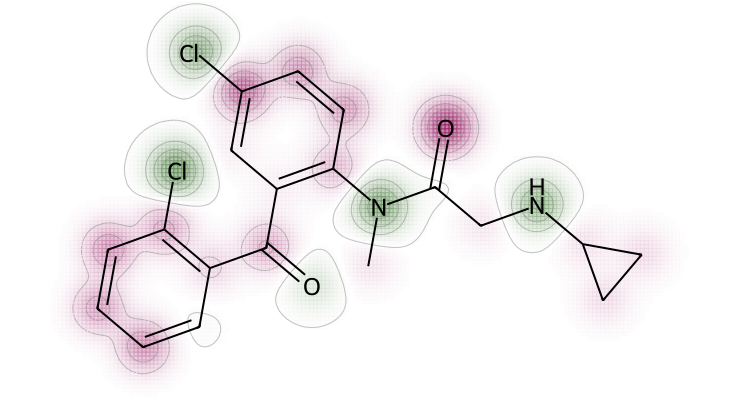

In [85]:
visualize_gradients('C1=C(Cl)C=CC(=C1C(C2=C(C=CC=C2)Cl)=O)N(C(CNC3CC3)=O)C')

### Green: Chlorine, secondary amine, tertiary amine

High-quality PNG file saved as Ciprazafone.png


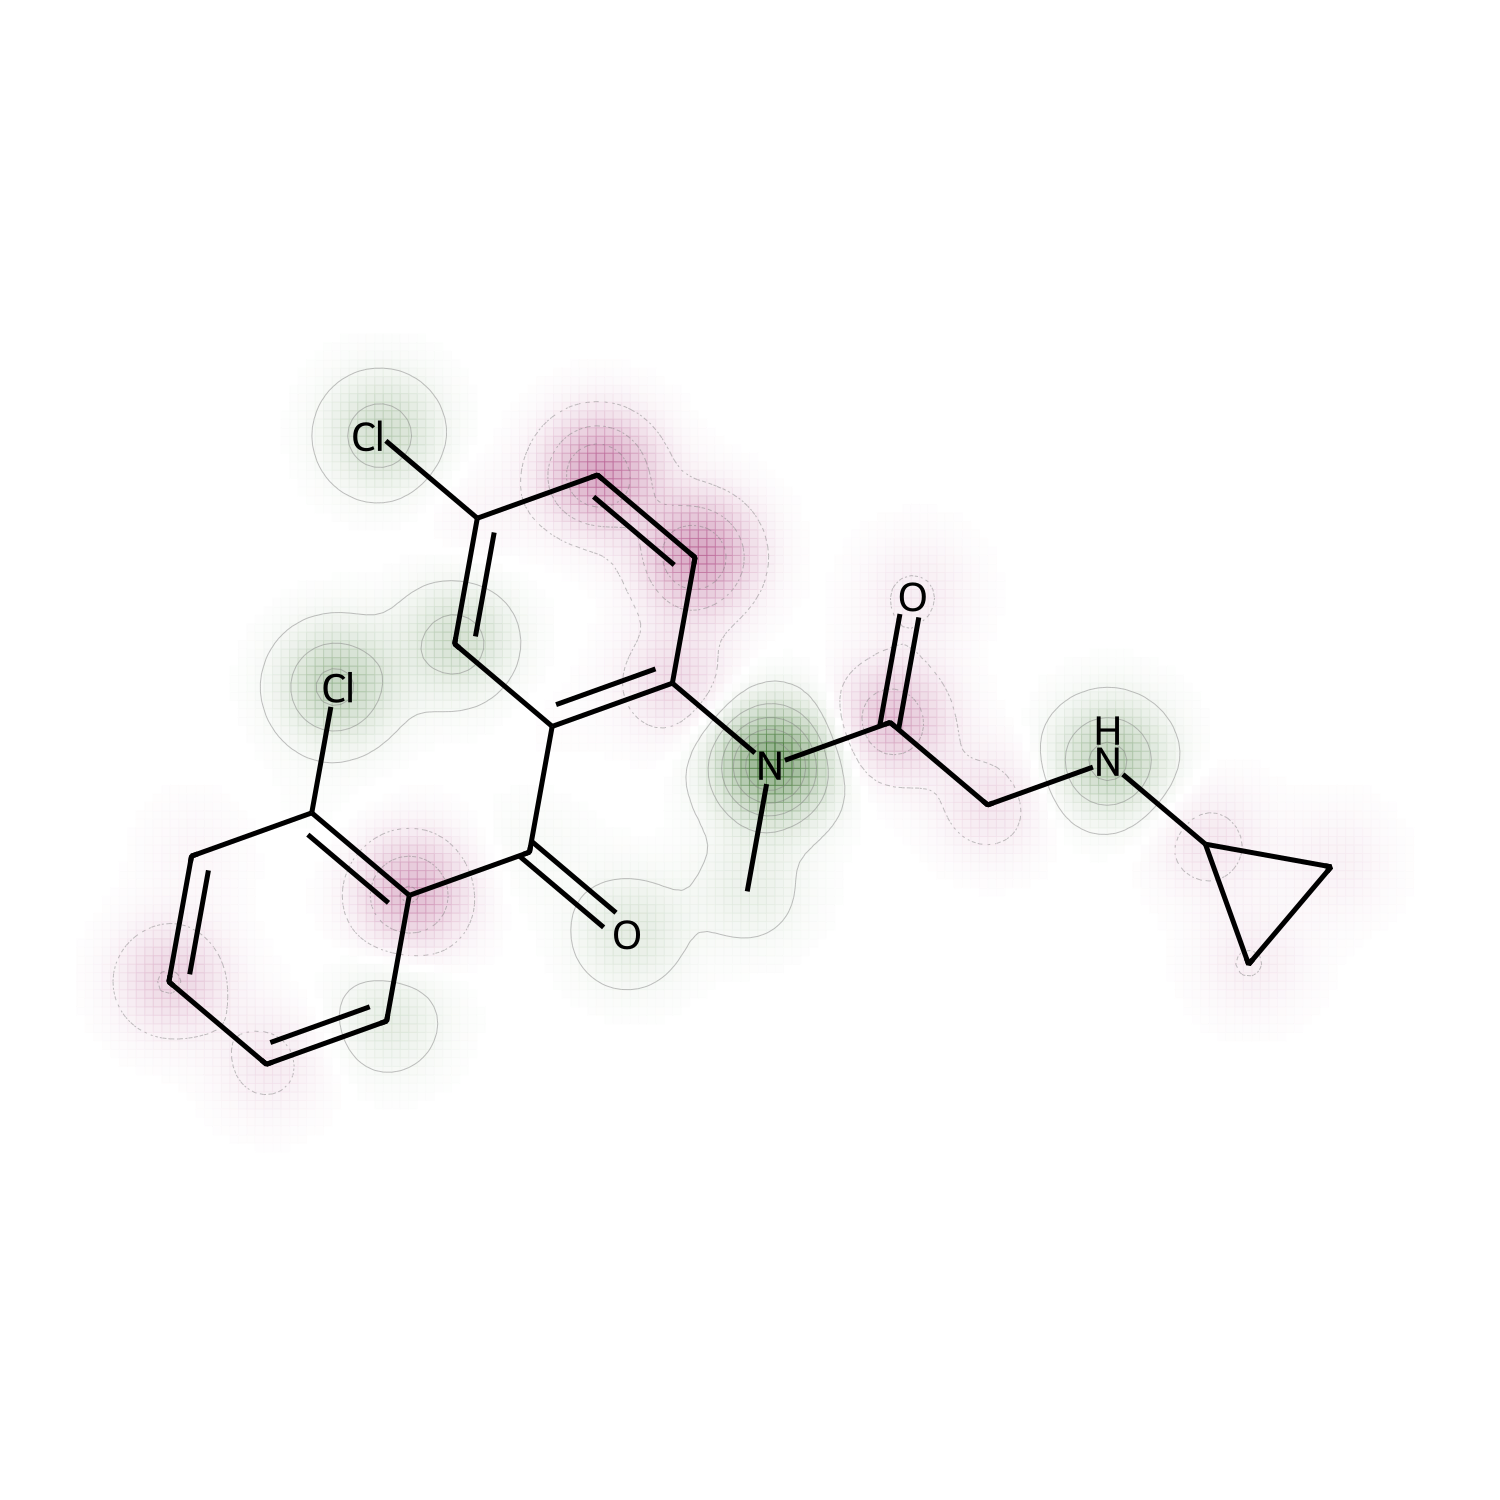

In [146]:
save_high_quality_png('C1=C(Cl)C=CC(=C1C(C2=C(C=CC=C2)Cl)=O)N(C(CNC3CC3)=O)C','Ciprazafone')

1
[[0.00107964 0.99892044]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', 0.13857321441173553), ('1', 0.39744502305984497), ('=', 0.4446989595890045), ('C', -0.08251863718032837), ('(', 0.5827742218971252), ('C', -0.2181115597486496), ('(', 0.009547585621476173), ('N', 0.12496690452098846), (')', 0.017262907698750496), ('=', 0.05217195674777031), ('O', -0.015982292592525482), (')', -0.012195941992104053), ('C', -0.04779456555843353), ('=', 0.016100382432341576), ('C', -0.006829937919974327), ('(', -0.009998558089137077), ('C', 0.002473406493663788), ('(', 0.025948507711291313), ('=', 0.0178696122020483), ('C', 0.02634354680776596), ('1', -0.02100859396159649), ('O', -0.05391563102602959), ('C', -0.011954802088439465), (')', -0.17244568467140198), ('O', -0.3076789379119873), ('C', 0.000470451865112409), ('C', -0.017160452902317047), ('C', -0.01596948504447937), ('C', -0.01680210791528225), ('C', -0.018350591883063316), ('C', -0.0002521041897125542), ('C', -0.016898222267627716)

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.13857321441173553, -0.08251863718032837, -0.2181115597486496, 0.12496690452098846, -0.015982292592525482, -0.04779456555843353, -0.006829937919974327, 0.002473406493663788, 0.02634354680776596, -0.05391563102602959, -0.011954802088439465, -0.3076789379119873, 0.000470451865112409, -0.017160452902317047, -0.01596948504447937, -0.01680210791528225, -0.018350591883063316, -0.0002521041897125542, -0.016898222267627716, -0.018693754449486732, -0.019411306828260422, -0.04448099434375763, -0.21496272087097168, 0.1539641171693802]


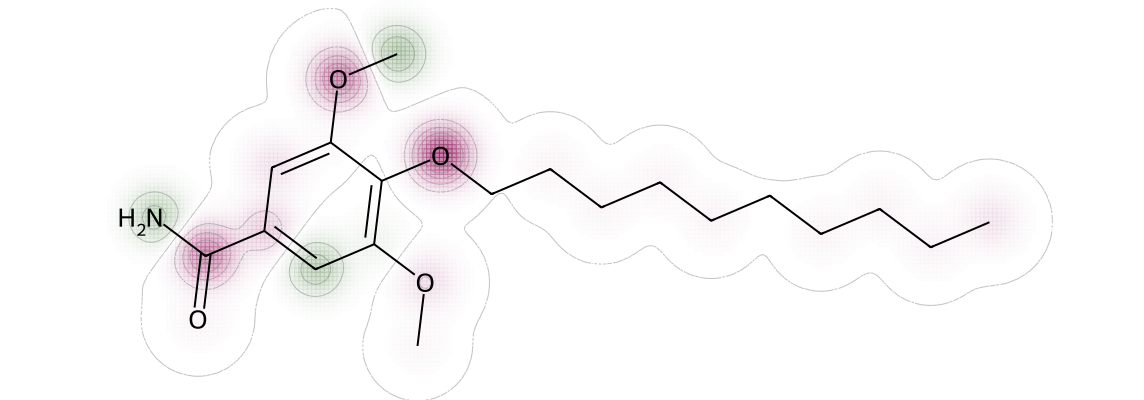

In [ ]:
visualize_gradients('C1=C(C(N)=O)C=C(C(=C1OC)OCCCCCCCCCC)OC')

### Green : Primary Amine

1
[[1.1497941e-04 9.9988496e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', -0.1299009472131729), ('1', 0.08829061686992645), ('=', 0.09290923923254013), ('C', -0.2292904555797577), ('C', -0.17176415026187897), ('=', 0.09318207949399948), ('C', -0.0028891554102301598), ('C', -0.03871496394276619), ('3', -0.0077209072187542915), ('=', 0.14615514874458313), ('C', 0.012943423353135586), ('1', -0.009337907657027245), ('N', 0.5171482563018799), ('(', 0.14632217586040497), ('C', -0.0815306156873703), ('C', 0.011926835402846336), ('C', -0.17760758101940155), ('N', 0.4306471049785614), ('2', -0.09465467184782028), ('C', -0.0045256647281348705), ('C', -0.028834862634539604), ('C', -0.04831516742706299), ('(', 0.31596839427948), ('O', 0.004780518356710672), ('C', -0.183322474360466), ('C', -0.23692753911018372), ('O', 0.05479074642062187), (')', 0.03345613181591034), ('C', 0.011665952391922474), ('C', 0.03075968287885189), ('2', -0.04272938519716263), (')', 0.12937946617603302), ('C

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [-0.1299009472131729, -0.2292904555797577, -0.17176415026187897, -0.0028891554102301598, -0.03871496394276619, 0.012943423353135586, 0.5171482563018799, -0.0815306156873703, 0.011926835402846336, -0.17760758101940155, 0.4306471049785614, -0.0045256647281348705, -0.028834862634539604, -0.04831516742706299, 0.004780518356710672, -0.183322474360466, -0.23692753911018372, 0.05479074642062187, 0.011665952391922474, 0.03075968287885189, -0.09525928646326065, -0.10283944010734558, -0.011334078386425972, -0.1005353108048439, -0.06289157271385193, -0.05949472635984421, -0.0674065500497818, -0.07456621527671814, 0.024441221728920937, 0.029788760468363762, 0.03504061698913574]


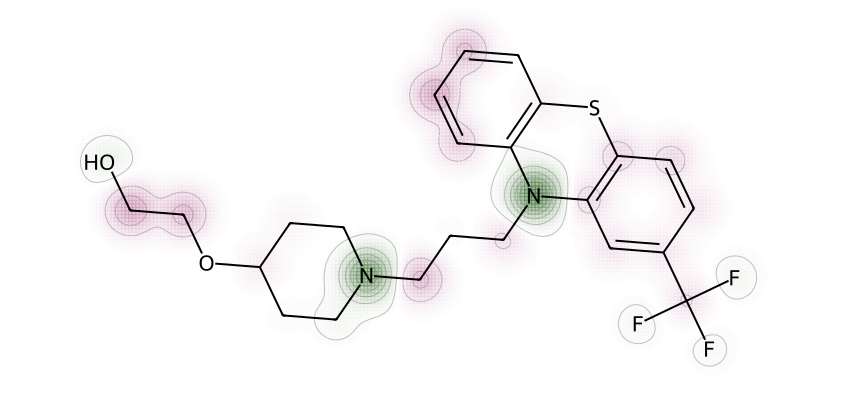

In [63]:
visualize_gradients('C1=CC=CC3=C1N(CCCN2CCC(OCCO)CC2)C4=C(S3)C=CC(=C4)C(F)(F)F')

### Green : Trifluoromethyl, Tertiary Amine

High-quality PNG file saved as Flupimazine1.png


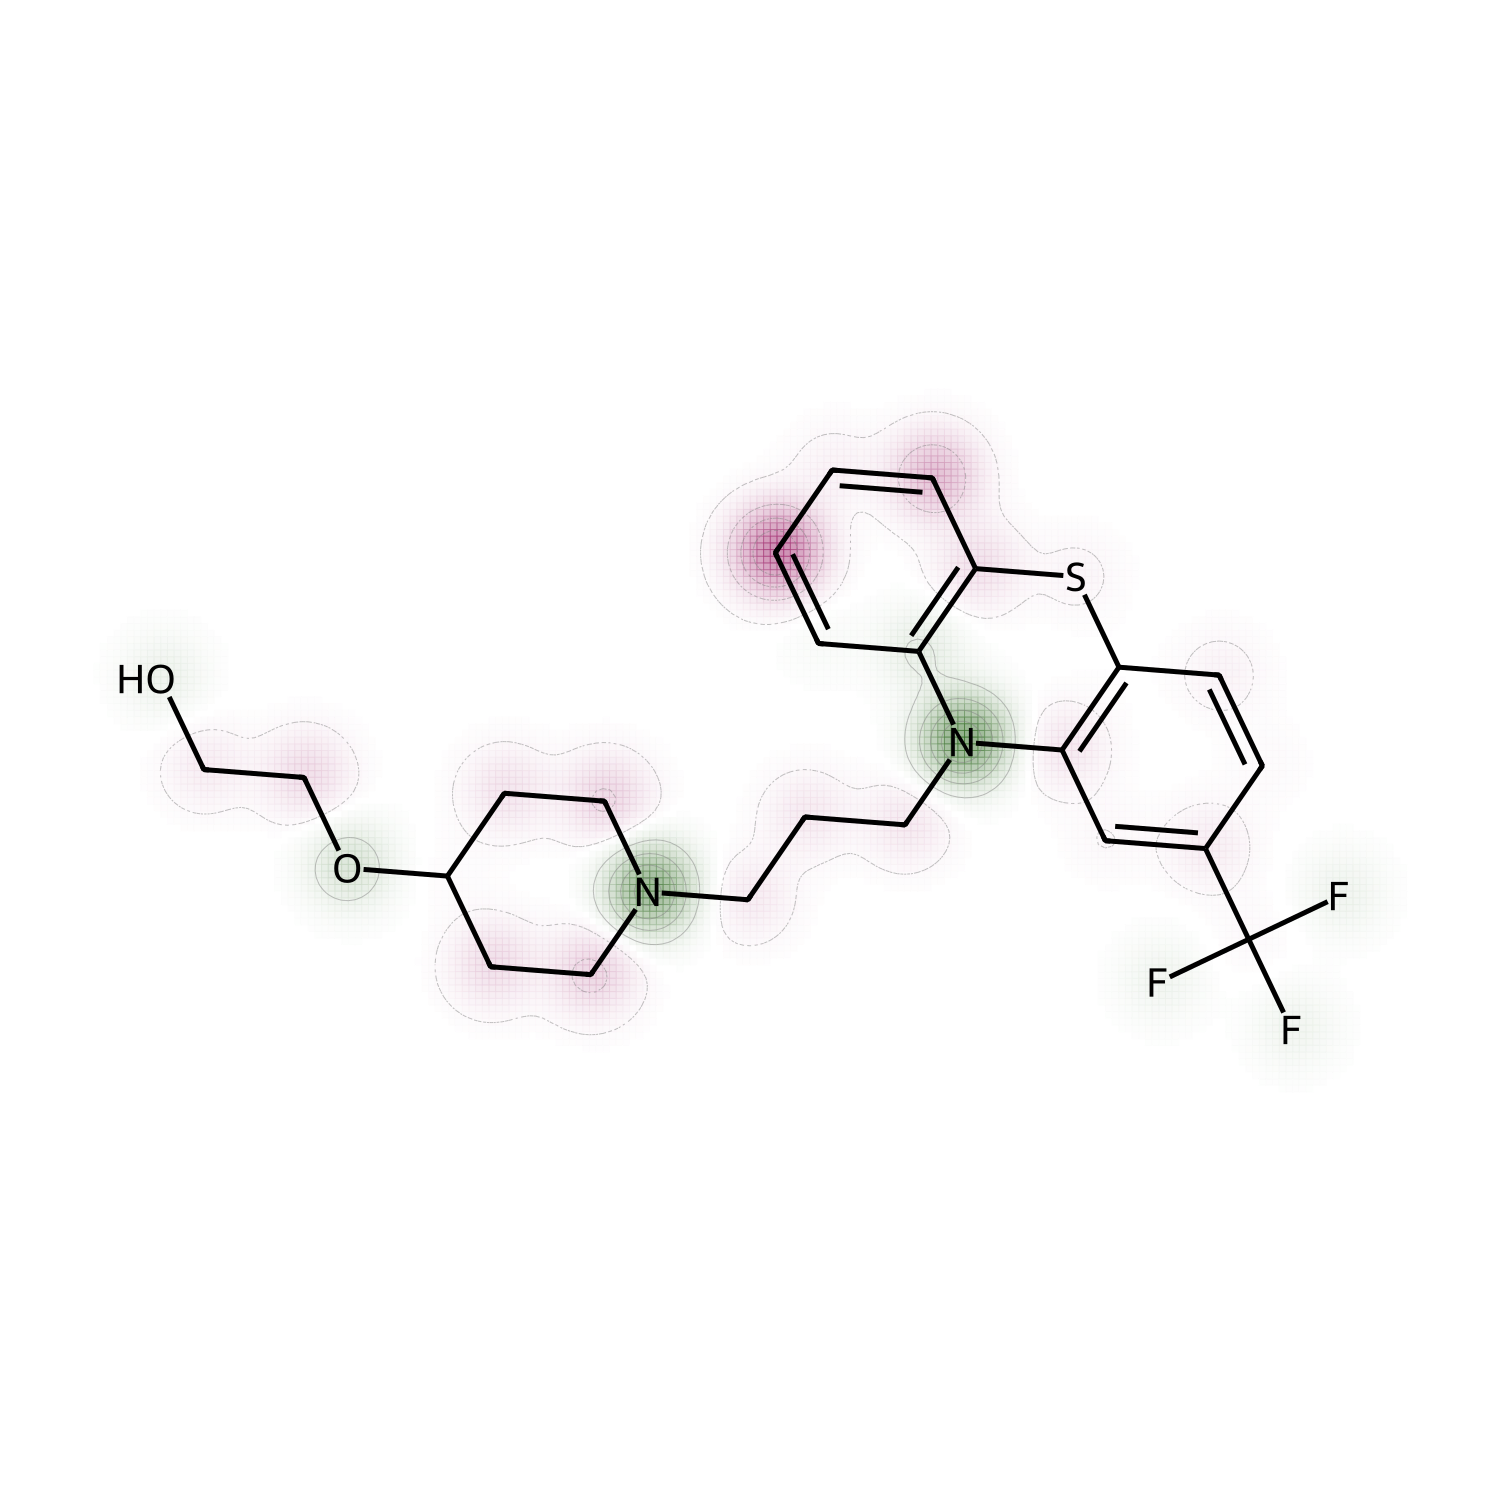

In [76]:
save_high_quality_png('C1=CC=CC3=C1N(CCCN2CCC(OCCO)CC2)C4=C(S3)C=CC(=C4)C(F)(F)F','Flupimazine1')

1
[[5.6734301e-05 9.9994326e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', -0.05324791371822357), ('1', 0.14199960231781006), ('=', 0.11539774388074875), ('C', -0.15656062960624695), ('C', -0.10713299363851547), ('=', 0.06702367961406708), ('C', -0.04491265118122101), ('C', -0.03840020298957825), ('=', 0.023935841396450996), ('C', -0.2008994221687317), ('1', 0.033935803920030594), ('N', 0.2380399852991104), ('2', 0.0096033476293087), ('C', -0.029210524633526802), ('5', 0.01081906445324421), ('(', 0.13446494936943054), ('C', 0.08815617859363556), ('(', 0.35587769746780396), ('N', 0.33957719802856445), ('C', -0.06645236164331436), ('2', -0.20520028471946716), (')', 0.018535066395998), ('=', 0.0593387596309185), ('O', -0.048527102917432785), (')', 0.051244817674160004), ('C', -0.15673837065696716), ('C', 0.005742968060076237), ('N', 0.3921947777271271), ('(', 0.3612900376319885), ('C', -0.060619648545980453), ('C', -0.014815699309110641), ('C', 0.0726640373468399), ('C', 0.0

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [-0.05324791371822357, -0.15656062960624695, -0.10713299363851547, -0.04491265118122101, -0.03840020298957825, -0.2008994221687317, 0.2380399852991104, -0.029210524633526802, 0.08815617859363556, 0.33957719802856445, -0.06645236164331436, -0.048527102917432785, -0.15673837065696716, 0.005742968060076237, 0.3921947777271271, -0.060619648545980453, -0.014815699309110641, 0.0726640373468399, 0.013549426570534706, 0.006347135175019503, 0.014902163296937943, 0.01352195255458355, 0.031779248267412186, -0.01671905629336834, -0.01888888329267502, 0.07691935449838638, -0.00963373202830553, -0.03004792146384716, -0.028087448328733444, -0.008786170743405819, -0.013800970278680325, 0.013345975428819656, 0.07604056596755981, -0.014928857795894146, 0.04571876674890518]


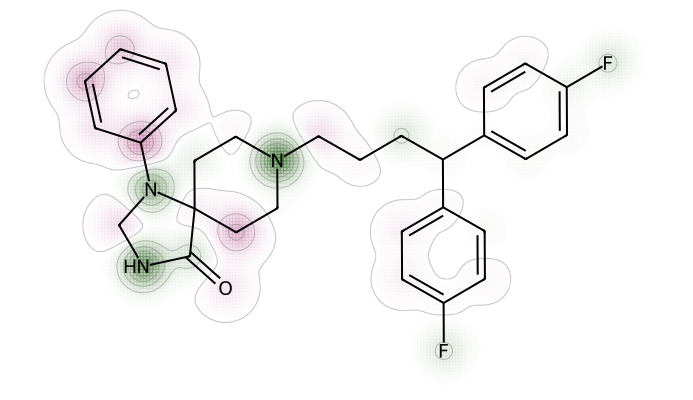

In [27]:
visualize_gradients('C1=CC=CC=C1N2C5(C(NC2)=O)CCN(CCCC(C3=CC=C(C=C3)F)C4=CC=C(C=C4)F)CC5')

### Green: (Imidazolidine)Secondary Amine, Tertiary Amine, Tertiary Amine, fluorine

1
[[2.7812054e-04 9.9972183e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', -0.04223918914794922), ('5', 6.0663358453894034e-05), ('=', 0.15244945883750916), ('C', -0.07972516864538193), ('(', 0.0376712903380394), ('C', -0.04891112074255943), ('(', 0.18550506234169006), ('C', 0.04182764142751694), ('N', 0.7224833369255066), ('1', 0.11220048367977142), ('C', 0.016323667019605637), ('2', 0.03790893778204918), ('C', -0.11219292879104614), ('4', -0.11840059608221054), ('C', -0.16016605496406555), ('(', 0.157479926943779), ('C', -0.07485838234424591), ('C', -0.04279268905520439), ('1', -0.02744978666305542), (')', -0.025152916088700294), ('(', 0.41957947611808777), ('C', 0.0011458180379122496), ('3', -0.059441305696964264), ('=', 0.021709976717829704), ('C', -0.05985378101468086), ('(', 0.12911158800125122), ('C', -0.04750437289476395), ('2', -0.058433081954717636), (')', -0.04362671449780464), ('C', -0.055954206734895706), ('=', 0.0319150872528553), ('C', -0.06186423450708389)

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [-0.04223918914794922, -0.07972516864538193, -0.04891112074255943, 0.04182764142751694, 0.7224833369255066, 0.016323667019605637, -0.11219292879104614, -0.16016605496406555, -0.07485838234424591, -0.04279268905520439, 0.0011458180379122496, -0.05985378101468086, -0.04750437289476395, -0.055954206734895706, -0.06186423450708389, -0.05598176270723343, -0.001704522524960339, 0.05284099653363228, -0.05212078616023064, -0.054592862725257874, -0.05427440628409386, -0.04058736562728882, 0.05386782065033913, -0.01806047186255455, -0.048758503049612045, -0.04825415089726448, -0.0011618827702477574]


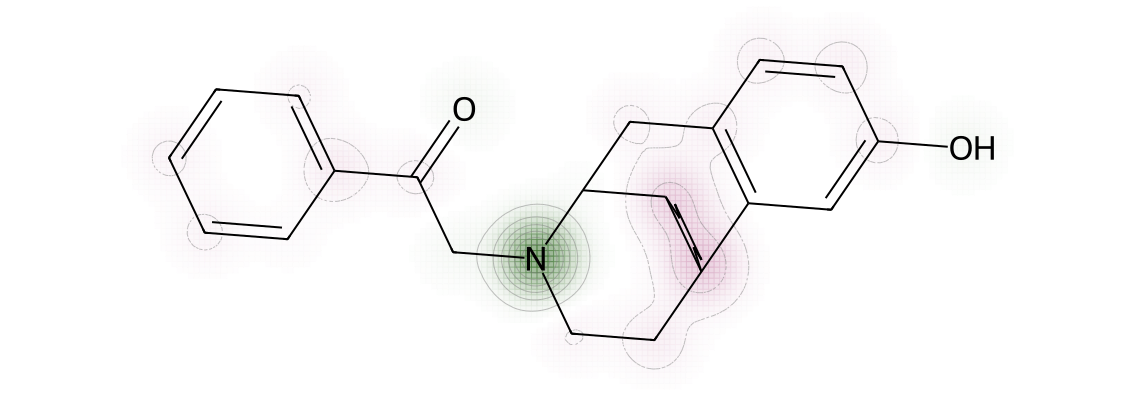

In [17]:
visualize_gradients('C5=C(C(CN1C2C4C(CC1)(C3=C(C2)C=CC(=C3)O)CCCC4)=O)C=CC=C5')

Green : Tertiary amine

1
[[4.5982062e-05 9.9995399e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', -0.10092820227146149), ('4', -0.1502581685781479), ('=', 0.13668875396251678), ('C', -0.1615743786096573), ('(', -0.16229888796806335), ('C', -0.192890927195549), ('(', -0.3321053683757782), ('C', -0.003037909045815468), ('3', 0.018235279247164726), ('C', -0.026090586557984352), ('C', -0.06618963927030563), ('N', 0.4211384356021881), ('(', 0.20554578304290771), ('C', -0.0070822895504534245), ('C', -0.09912536293268204), ('C', -0.18665502965450287), ('1', 0.2746681272983551), ('=', 0.007468771655112505), ('C', -0.1397886872291565), ('(', 0.01502561941742897), ('N', 0.053160447627305984), ('=', 0.1497316062450409), ('C', 0.035559382289648056), ('2', -0.053327132016420364), ('N', 0.20137180387973785), ('(', -0.1357148438692093), ('C', -0.0063806395046412945), ('1', 0.2652319073677063), ('=', -0.013109644874930382), ('O', 0.04855402559041977), (')', 0.03976445272564888), ('C', 0.013375343754887581), ('

/tmp/ipykernel_2356665/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [-0.10092820227146149, -0.1615743786096573, -0.192890927195549, -0.003037909045815468, -0.026090586557984352, -0.06618963927030563, 0.4211384356021881, -0.0070822895504534245, -0.09912536293268204, -0.18665502965450287, -0.1397886872291565, 0.053160447627305984, 0.035559382289648056, 0.20137180387973785, -0.0063806395046412945, 0.04855402559041977, 0.013375343754887581, -0.02428392879664898, 0.03414812684059143, 0.17115144431591034, 0.20013068616390228, 0.047655314207077026, 0.09397684782743454, -0.03725280612707138, -0.05939937382936478, -0.051372189074754715, -0.0701841413974762, 0.041462481021881104]


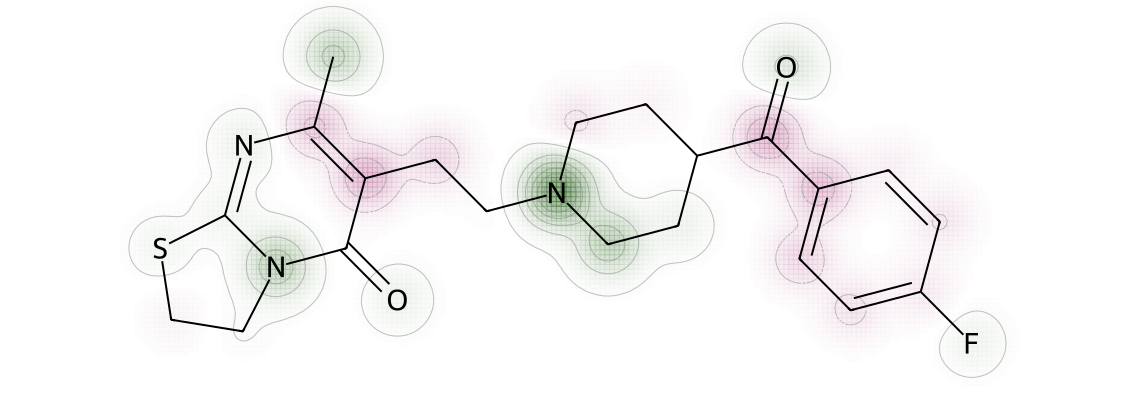

In [ ]:
visualize_gradients('C4=C(C(C3CCN(CCC1=C(N=C2N(C1=O)CCS2)C)CC3)=O)C=CC(=C4)F')

### Green : Pyrimidine, suphur group

High-quality PNG file saved as Setoperone.png


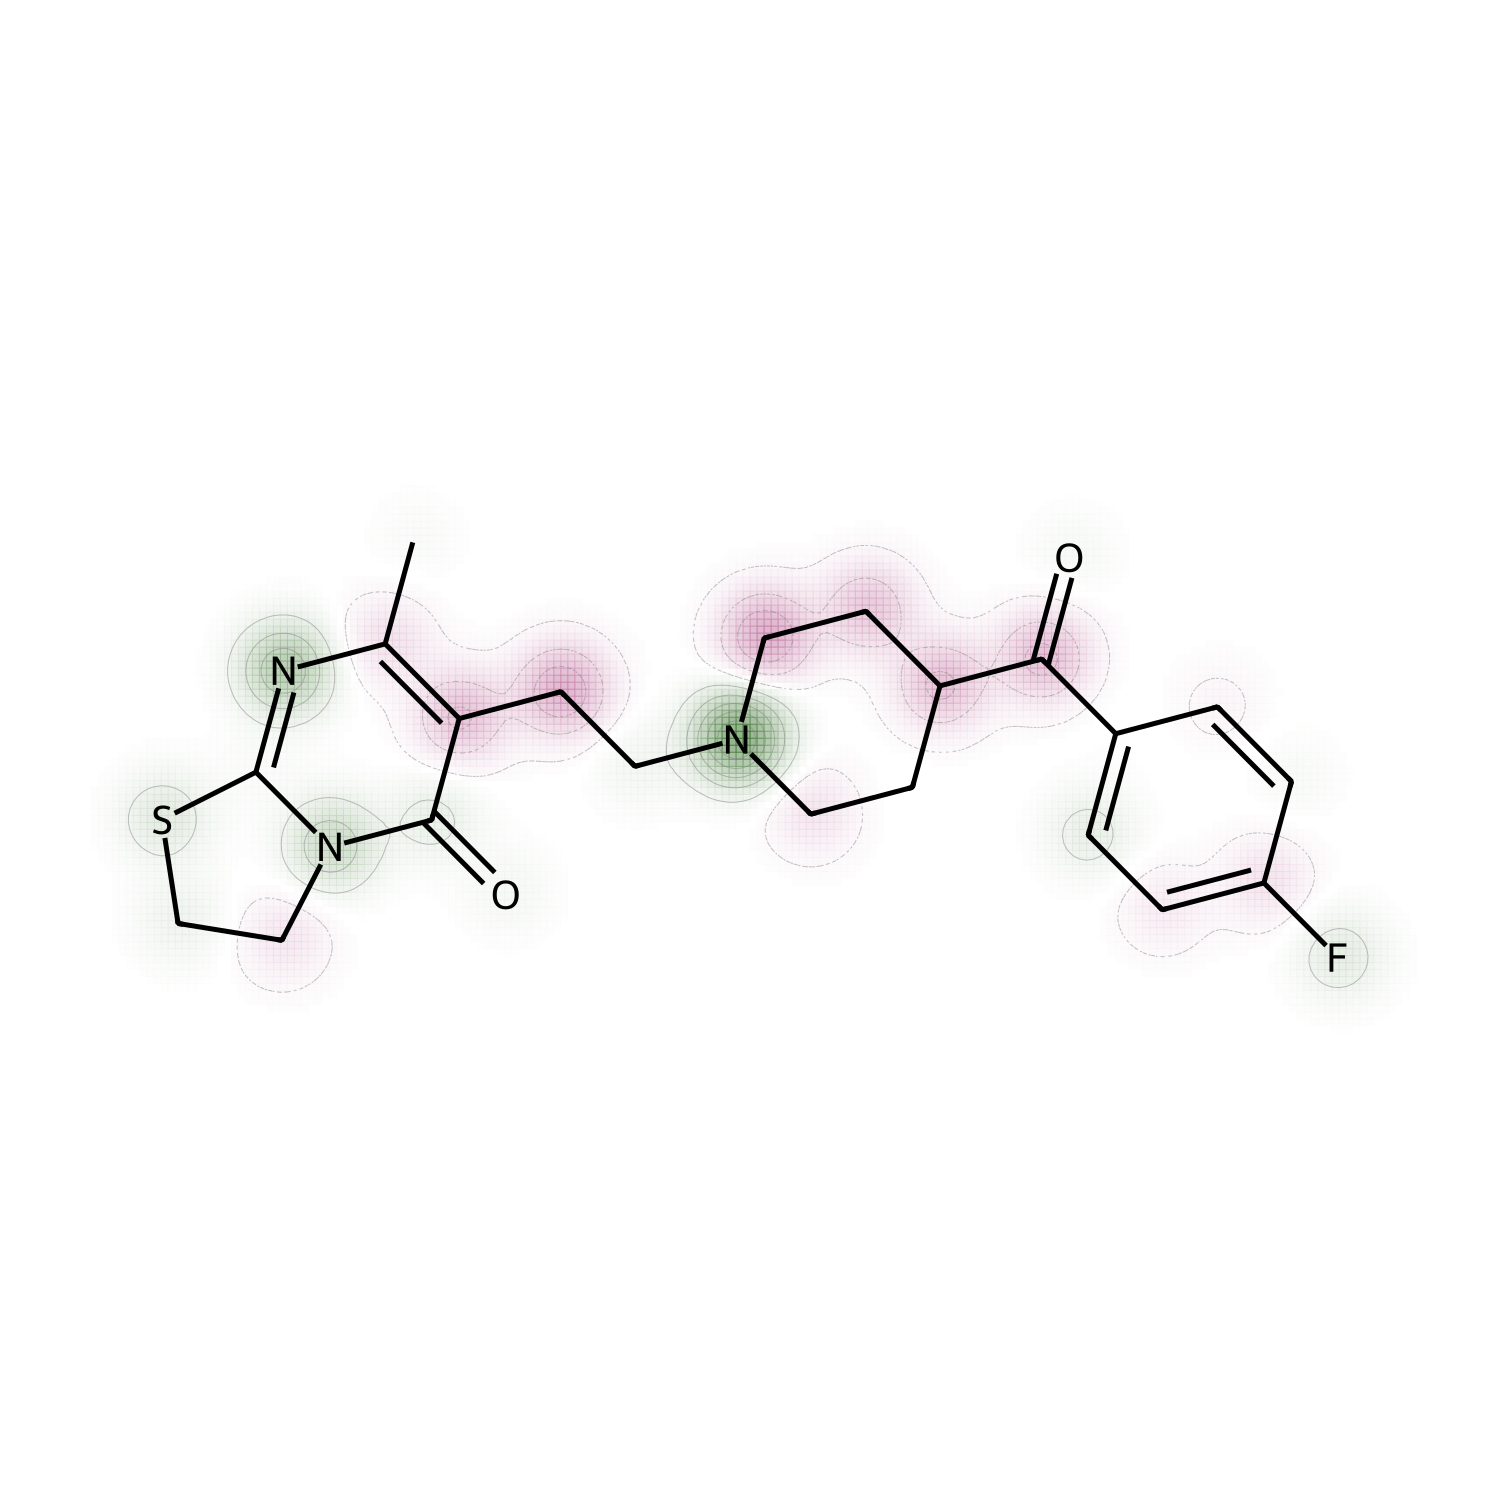

In [51]:
save_high_quality_png('C4=C(C(C3CCN(CCC1=C(N=C2N(C1=O)CCS2)C)CC3)=O)C=CC(=C4)F','Setoperone')

1
[[2.4452872e-04 9.9975544e-01]]
1 score: 1.00


Token Importance: [('<bos>', 0.0), ('C', 0.16041581332683563), ('(', -0.07680308073759079), ('C', -0.35368141531944275), ('(', -0.07549306005239487), ('O', 0.19248659908771515), ('C', 0.22767996788024902), ('(', -0.10650545358657837), ('C', -0.022693397477269173), ('(', 0.19137994945049286), ('Cl', 0.21270902454853058), (')', 0.0006269938894547522), ('(', 0.026379089802503586), ('Cl', 0.06953112781047821), (')', -0.01318035926669836), ('Cl', 0.146135613322258), (')', 0.1373298466205597), ('O', -0.47575002908706665), (')', -0.11242111772298813), ('C', 0.20781205594539642), (')', -0.02652379684150219), ('C', 0.0038479336071759462), ('(', -0.11007791757583618), ('C', 0.006560881622135639), (')', 0.22976525127887726), ('(', -0.08128230273723602), ('C', -0.07751278579235077), (')', 0.3724910318851471), ('O', -0.3314242362976074), ('<eos>', 0.0)]


/tmp/ipykernel_2356665/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.16041581332683563, -0.35368141531944275, 0.19248659908771515, 0.22767996788024902, -0.022693397477269173, 0.21270902454853058, 0.06953112781047821, 0.146135613322258, -0.47575002908706665, 0.20781205594539642, 0.0038479336071759462, 0.006560881622135639, -0.07751278579235077, -0.3314242362976074]


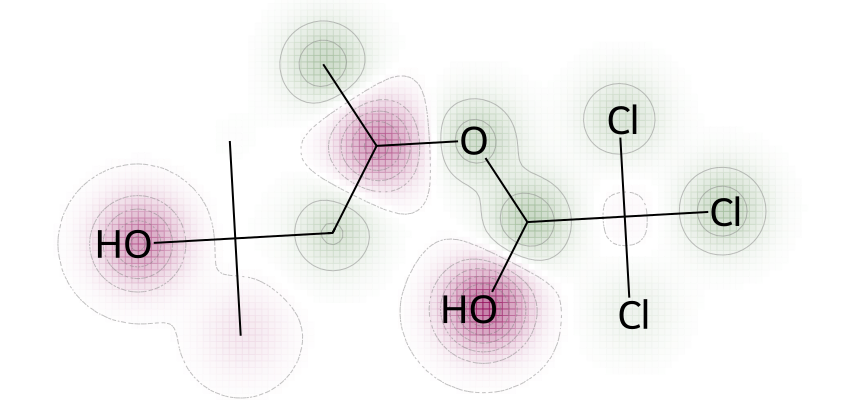

In [144]:
visualize_gradients('C(C(OC(C(Cl)(Cl)Cl)O)C)C(C)(C)O')

### green : Trichloromethyl,Ether, Red: Hydroxy

1
[[5.550928e-04 9.994449e-01]]
1 score: 1.00


Token Importance: [('<bos>', 0.0), ('C', 0.12736216187477112), ('(', 0.20322442054748535), ('N', 0.34133243560791016), ('1', 0.16704444587230682), ('C', -0.15910537540912628), ('(', 0.268770694732666), ('C', 0.01691468246281147), ('(', -0.04999075084924698), ('C', 0.13113322854042053), (')', 0.07102872431278229), ('O', -0.050400346517562866), ('C', -0.0604558065533638), ('1', -0.13776637613773346), ('=', -0.08552791178226471), ('O', -0.6448476910591125), (')', 0.10283150523900986), ('=', -0.01776941679418087), ('O', -0.3537787199020386), (')', 0.26530721783638), ('C', -0.13786059617996216), ('=', 0.025396322831511497), ('C', 0.03290148079395294), ('<eos>', 0.0)]


/tmp/ipykernel_2356665/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.12736216187477112, 0.34133243560791016, -0.15910537540912628, 0.01691468246281147, 0.13113322854042053, -0.050400346517562866, -0.0604558065533638, -0.6448476910591125, -0.3537787199020386, -0.13786059617996216, 0.03290148079395294]


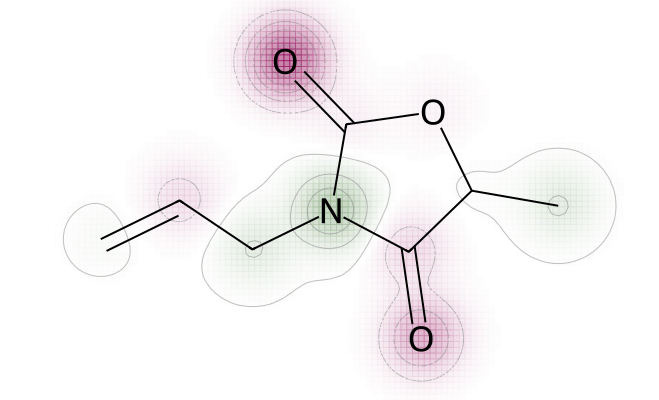

In [59]:
molecule= 'C(N1C(C(C)OC1=O)=O)C=C'
visualize_gradients(molecule)

1
[[4.2975994e-04 9.9957019e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', 0.15528987348079681), ('1', 0.1780342012643814), ('=', 0.22313664853572845), ('C', -0.07767421752214432), ('C', -0.12326128035783768), ('=', 0.09041061997413635), ('C', -0.1327870488166809), ('2', -0.03626694157719612), ('C', -0.14707380533218384), ('(', 0.2812221646308899), ('=', 0.1592143476009369), ('C', 0.07779470831155777), ('1', -0.0228304211050272), (')', -0.18169546127319336), ('S', -0.05699143931269646), ('C', 0.08472170680761337), ('3', -0.06865086406469345), ('=', 0.19334614276885986), ('C', 0.04730169102549553), ('(', 0.12815828621387482), ('N', 0.31230589747428894), ('2', -0.03526054695248604), ('C', -0.22956322133541107), ('C', 0.003001662902534008), ('(', 0.5205584168434143), ('C', 0.036395300179719925), (')', -0.05287209898233414), ('C', 0.02808895893394947), ('N', 0.20229515433311462), ('(', 0.0027532835956662893), ('C', -0.15979492664337158), (')', -0.15756160020828247), ('C', -0.

/tmp/ipykernel_2356665/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.15528987348079681, -0.07767421752214432, -0.12326128035783768, -0.1327870488166809, -0.14707380533218384, 0.07779470831155777, -0.05699143931269646, 0.08472170680761337, 0.04730169102549553, 0.31230589747428894, -0.22956322133541107, 0.003001662902534008, 0.036395300179719925, 0.02808895893394947, 0.20229515433311462, -0.15979492664337158, -0.18259674310684204, -0.05150074139237404, -0.04096488654613495, 0.061873018741607666, -0.05748821794986725, -0.07619116455316544, 0.0386386439204216, 0.08782920241355896, 0.03369439020752907]


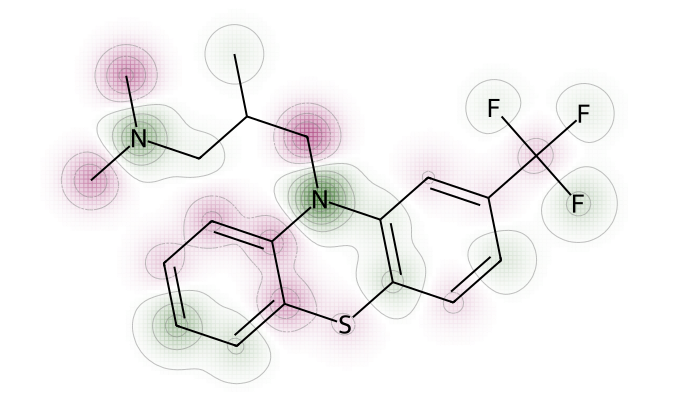

In [ ]:
visualize_gradients('C1=CC=C2C(=C1)SC3=C(N2CC(C)CN(C)C)C=C(C=C3)C(F)(F)F')

High-quality PNG file saved as Trifluomeprazine1.png


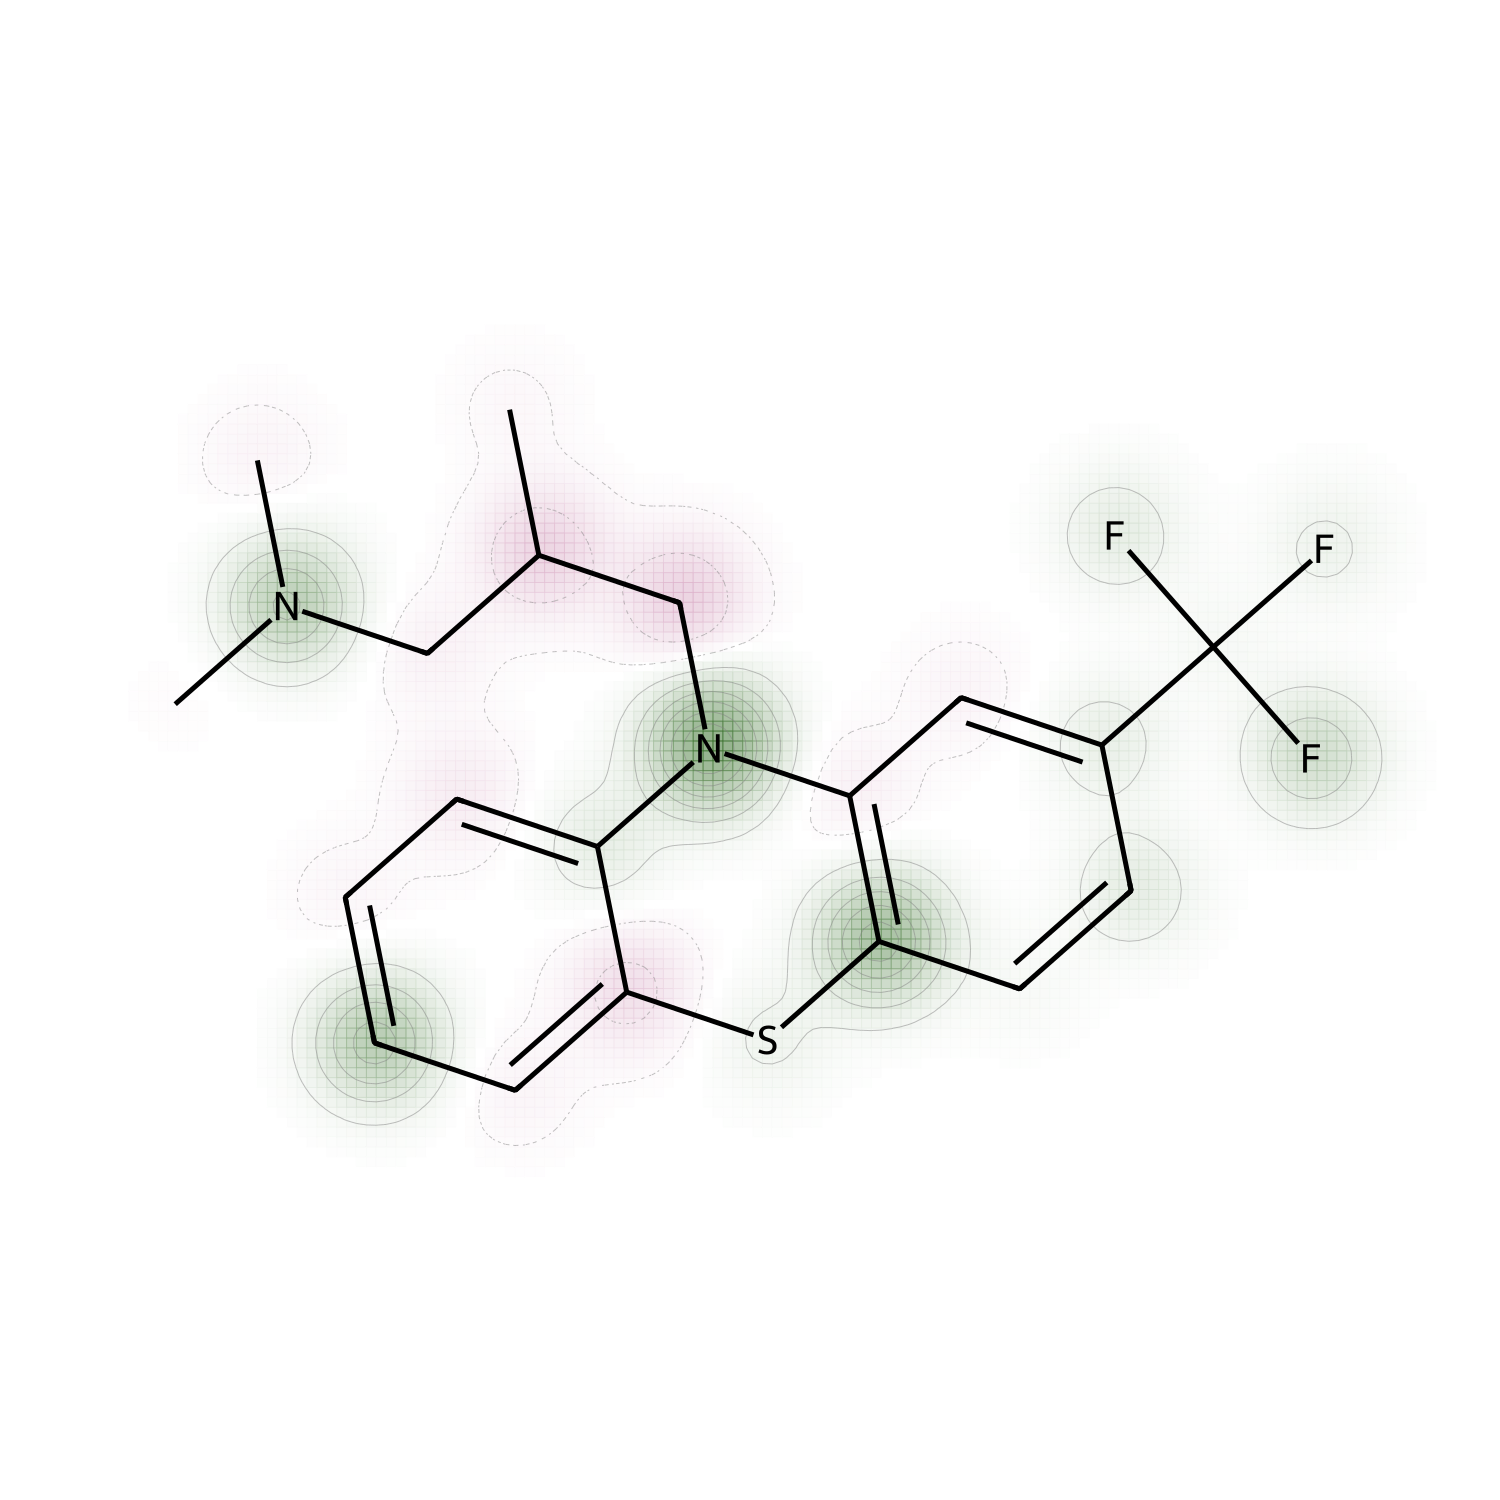

In [145]:
save_high_quality_png('C1=CC=C2C(=C1)SC3=C(N2CC(C)CN(C)C)C=C(C=C3)C(F)(F)F','Trifluomeprazine1') 

### Green Functional group: Tertiary Amine, Trifluoromethyl

1
[[2.2363916e-05 9.9997759e-01]]
1 score: 1.00


Token Importance: [('<bos>', 0.0), ('C', 0.2259225696325302), ('1', 0.2902035713195801), ('=', 0.23707403242588043), ('C', -0.1911906599998474), ('C', 0.03540760278701782), ('(', 0.24872873723506927), ('=', 0.12316965311765671), ('C', -0.08652302622795105), ('3', -0.10163013637065887), ('C', -0.21791549026966095), ('2', -0.012859009206295013), ('=', 0.12396511435508728), ('C', -0.04198366403579712), ('1', -0.035107772797346115), ('C', -0.16504327952861786), ('C', -0.1648349016904831), ('6', -0.010527229867875576), ('C', -0.014226601459085941), ('4', -0.03197194263339043), ('C', 0.05101126804947853), ('2', 0.07809445261955261), ('(', 0.15202262997627258), ('C', -0.09446955472230911), ('(', 0.13600300252437592), ('O', 0.1535429209470749), ('3', -0.02105139195919037), (')', 0.05389172583818436), ('C', -0.26923230290412903), ('(', -0.02914516068994999), ('C', -0.021139109507203102), ('C', -0.0898221954703331), ('4', 0.08347836136817932), (')', -0.15628212690353394), ('O', 0.101826041936874

/tmp/ipykernel_663187/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.2259225696325302, -0.1911906599998474, 0.03540760278701782, -0.08652302622795105, -0.21791549026966095, -0.04198366403579712, -0.16504327952861786, -0.1648349016904831, -0.014226601459085941, 0.05101126804947853, -0.09446955472230911, 0.1535429209470749, -0.26923230290412903, -0.021139109507203102, -0.0898221954703331, 0.10182604193687439, -0.22389563918113708, -0.059739984571933746, -0.16533955931663513, 0.365841805934906, -0.06361836940050125, -0.047736890614032745, 0.05814196169376373, 0.05622471868991852, -0.02761934883892536, -0.01585966907441616, 0.22887204587459564, -0.017360031604766846, -0.08599624037742615, -0.008958880789577961]


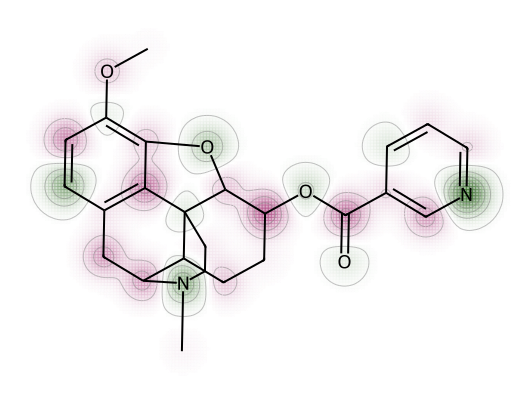

In [95]:
visualize_gradients('C1=CC(=C3C2=C1CC6C4C2(C(O3)C(CC4)OC(C5=CN=CC=C5)=O)CCN6C)OC')

### Postive FG: Acyl group. tertiary amine, one ether,Piperidine,Pyridine (N)

1
[[1.9667918e-05 9.9998033e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', 0.19924937188625336), ('1', 0.03181648626923561), ('=', 0.34067967534065247), ('C', -0.012303151190280914), ('C', -0.13139037787914276), ('=', 0.2028130143880844), ('C', -0.09382908046245575), ('C', -0.17201797664165497), ('2', -0.026973670348525047), ('=', 0.10857142508029938), ('C', -0.033906467258930206), ('1', 0.16622430086135864), ('C', 0.02199579030275345), ('(', 0.18607158958911896), ('C', 0.15035480260849), ('3', -0.1418207287788391), ('=', 0.02083165943622589), ('C', 0.13751934468746185), ('(', 0.36277881264686584), ('C', 0.20907965302467346), ('=', -0.029526880010962486), ('C', 0.1730436086654663), ('2', -0.3135959506034851), (')', 0.15812039375305176), ('C', 0.042529165744781494), ('=', -0.004792110063135624), ('C', 0.11237461119890213), ('C', 0.005067785736173391), ('=', 0.009172704070806503), ('C', -0.023145806044340134), ('3', -0.22126154601573944), (')', 0.0008474938222207129), ('=',

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.19924937188625336, -0.012303151190280914, -0.13139037787914276, -0.09382908046245575, -0.17201797664165497, -0.033906467258930206, 0.02199579030275345, 0.15035480260849, 0.13751934468746185, 0.20907965302467346, 0.1730436086654663, 0.042529165744781494, 0.11237461119890213, 0.005067785736173391, -0.023145806044340134, 0.28299424052238464, -0.06658243387937546, 0.029622375965118408, 0.04821809008717537, 0.19266903400421143, -0.2331908494234085]


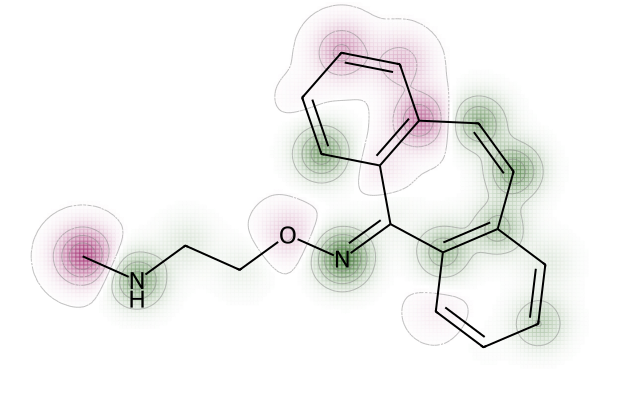

In [200]:
visualize_gradients('C1=CC=CC2=C1C(C3=C(C=C2)C=CC=C3)=NOCCNC')

### Green: Acyl group, secondary amine

High-quality PNG file saved as Demexiptiline.png


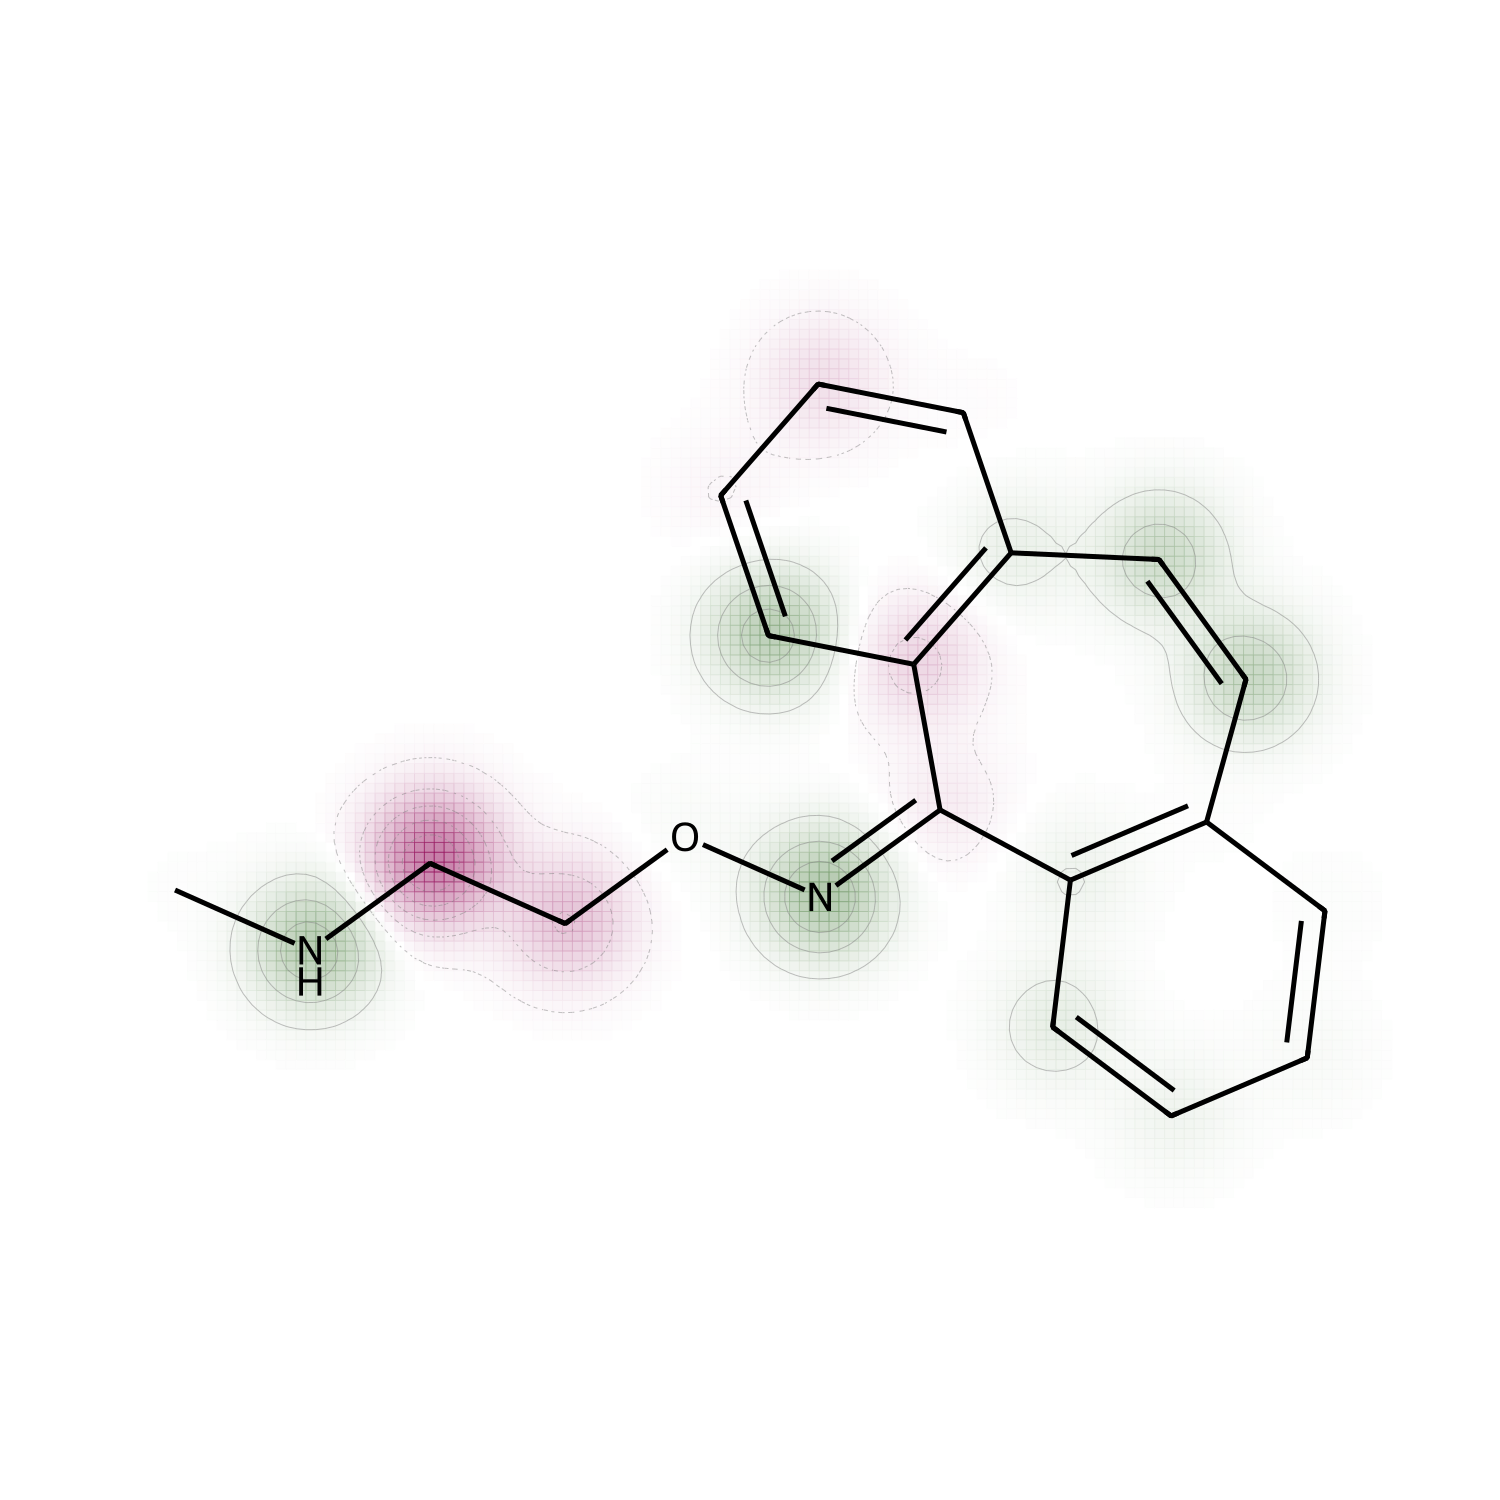

In [41]:
save_high_quality_png('C1=CC=CC2=C1C(C3=C(C=C2)C=CC=C3)=NOCCNC','Demexiptiline')

1
[[3.661125e-05 9.999634e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', 0.047518715262413025), ('1', 0.15338949859142303), ('=', 0.23468700051307678), ('C', 0.08294876664876938), ('C', -0.002430286491289735), ('=', -0.06132562458515167), ('C', -0.06489976495504379), ('C', -0.18414713442325592), ('=', 0.04796937108039856), ('C', -0.12021586298942566), ('1', -0.013936722651124), ('C', -0.17747539281845093), ('(', 0.3210151791572571), ('C', -0.1383170634508133), ('2', -0.07908570766448975), ('=', -0.008607910946011543), ('C', -0.1425507664680481), ('C', -0.18632090091705322), ('=', -0.06244977191090584), ('C', -0.10828866064548492), ('C', -0.13359789550304413), ('=', -0.03272272273898125), ('C', 0.0362679585814476), ('2', -0.011477071791887283), (')', 0.05998411402106285), ('O', -0.053578153252601624), ('C', -0.023622991517186165), ('C', 0.054357439279556274), ('N', 0.468090295791626), ('(', 0.5540692210197449), ('C', 0.08484296500682831), ('\\', 0.02716250903904438), ('C',

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.047518715262413025, 0.08294876664876938, -0.002430286491289735, -0.06489976495504379, -0.18414713442325592, -0.12021586298942566, -0.17747539281845093, -0.1383170634508133, -0.1425507664680481, -0.18632090091705322, -0.10828866064548492, -0.13359789550304413, 0.0362679585814476, -0.053578153252601624, -0.023622991517186165, 0.054357439279556274, 0.468090295791626, 0.08484296500682831, 0.05289308354258537, 0.0386698953807354, 0.004781423602253199, -0.03136567771434784, -0.04098372906446457, -0.061723873019218445, -0.022396160289645195, 0.07377838343381882, 0.004030488897114992]


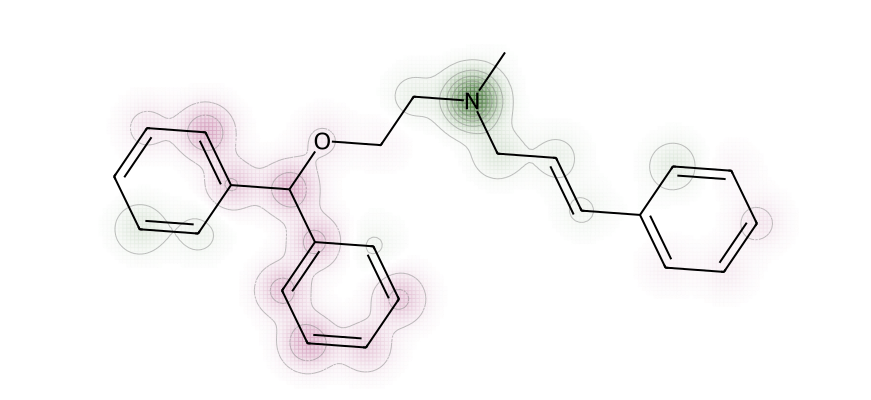

In [214]:
visualize_gradients('C1=CC=CC=C1C(C2=CC=CC=C2)OCCN(C\C=C\C3=CC=CC=C3)C')

### Green: Tertiary Amine

1
[[2.3220148e-04 9.9976784e-01]]
1 score: 1.00
Token Importance: [('<bos>', 0.0), ('C', 0.10735443979501724), ('1', 0.2075209617614746), ('=', 0.2192172408103943), ('C', -0.1704992800951004), ('C', -0.23399528861045837), ('=', 0.06649500876665115), ('C', -0.10284120589494705), ('C', -0.13041631877422333), ('(', 0.2885883152484894), ('=', -0.04719823598861694), ('C', -0.2769613564014435), ('1', 0.14894580841064453), ('O', -0.15463945269584656), ('C', -0.020800583064556122), ('C', -0.08920270949602127), ('(', -0.07215941697359085), ('C', -0.012149457819759846), ('O', 0.023741018027067184), ('C', -0.1252274066209793), ('(', 0.28894463181495667), ('C', -0.14384426176548004), ('(', -0.08807903528213501), ('Cl', 0.0676969364285469), (')', 0.08035596460103989), ('(', 0.3017045259475708), ('Cl', 0.12866069376468658), (')', 0.26269620656967163), ('Cl', 0.1265929490327835), (')', 0.12620708346366882), ('O', -0.09167325496673584), (')', 0.10643836855888367), ('O', -0.018133869394659996), ('C', -

/tmp/ipykernel_2399875/4234920843.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap=matplotlib.cm.get_cmap("Blues")


atom imp [0.10735443979501724, -0.1704992800951004, -0.23399528861045837, -0.10284120589494705, -0.13041631877422333, -0.2769613564014435, -0.15463945269584656, -0.020800583064556122, -0.08920270949602127, -0.012149457819759846, 0.023741018027067184, -0.1252274066209793, -0.14384426176548004, 0.0676969364285469, 0.12866069376468658, 0.1265929490327835, -0.09167325496673584, -0.018133869394659996, -0.004466216079890728, 0.03417252376675606, 0.03267139941453934, -0.025412948802113533, 0.24884313344955444, -0.12651148438453674, 0.16587220132350922]


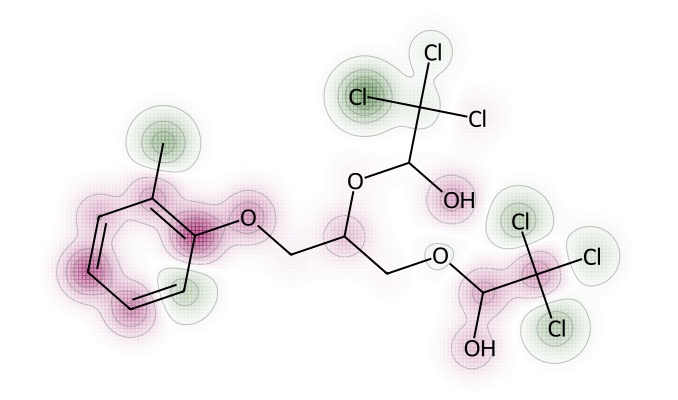

In [241]:
visualize_gradients('C1=CC=CC(=C1OCC(COC(C(Cl)(Cl)Cl)O)OC(C(Cl)(Cl)Cl)O)C')

### Green: Trichloromethyl

High-quality PNG file saved as Toloxychlorinol.png


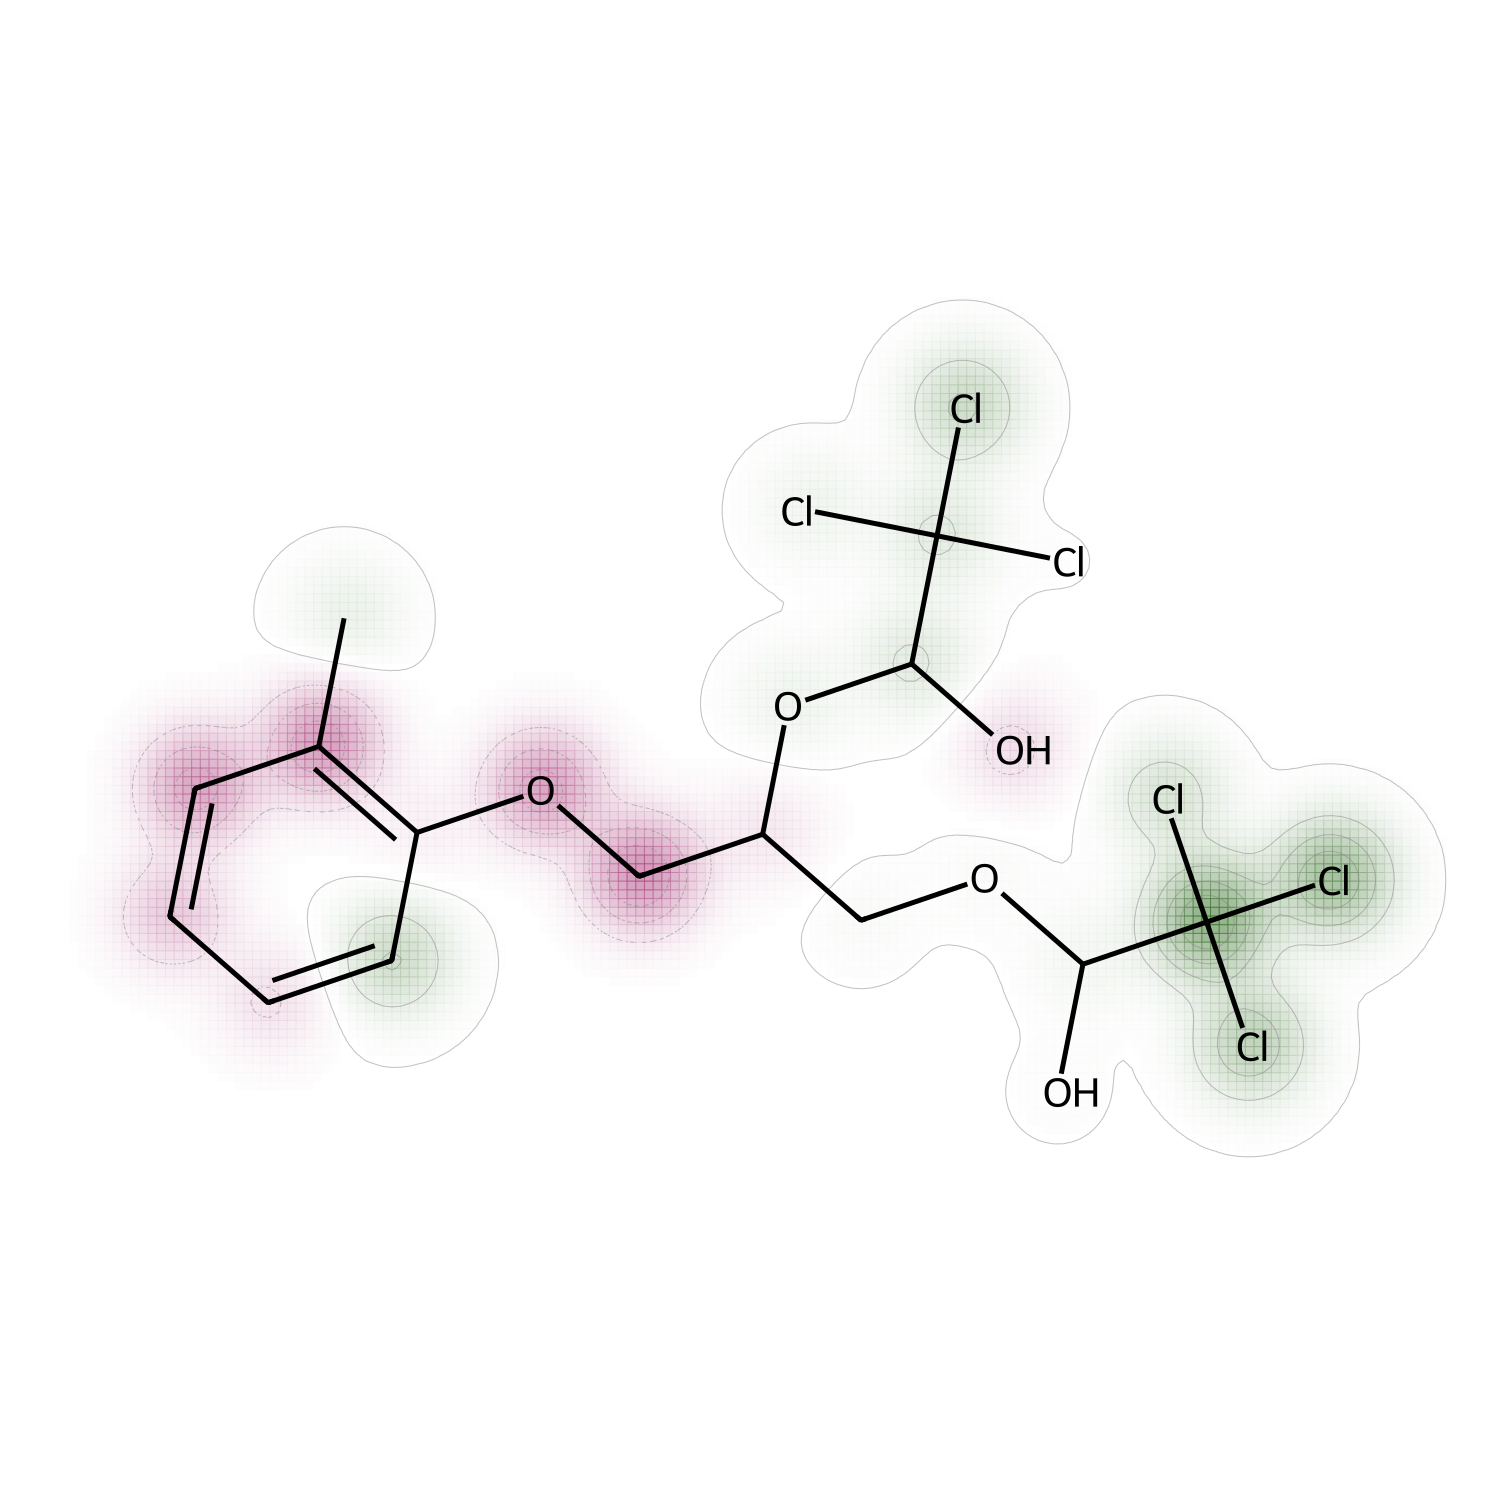

In [28]:
save_high_quality_png('C1=CC=CC(=C1OCC(COC(C(Cl)(Cl)Cl)O)OC(C(Cl)(Cl)Cl)O)C','Toloxychlorinol')